## Instalaciones necesarias

In [1]:
#%pip install plotly kaleido 
#%pip install bokeh matplotlib seaborn 
#%pip install nbformat
#%pip install torchsummary 

## Librerías

In [2]:
# Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image # Para abrir y examinar imágenes
import matplotlib.pyplot as plt
import seaborn as sns # Para visualizaciones de datos

from sklearn.model_selection import train_test_split

# Importar el módulo de redes neuronales de PyTorch
import torch.nn as nn
import torch.nn.functional as F # Para funciones de activación, pooling, etc.
from torchsummary import summary

# Importar librerías necesarias
import torch.nn as nn
import torch.optim as optim
import time
import os
import gc
import copy # Para copiar el mejor modelo/estado

# Importar librería Optuna
import optuna

import plotly.graph_objects as go
import optuna.visualization as vis

# Importar librerías necesarias para evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torchvision
from PIL import Image # Para visualización

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Configuración

In [3]:
# Selección de Dispositivo (CPU/GPU)
# Selecciona el dispositivo PyTorch. Prioriza CUDA (GPU NVIDIA) si está disponible.
# Es crucial mover modelos y tensores a este dispositivo para aprovechar la GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")
if device.type == 'cuda':
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total de la GPU: {torch.cuda.get_device_properties(0).total_memory / (1024**2):.2f} MB") # Mostrar VRAM total
    # Limpiar caché de VRAM al inicio si es necesario (útil si re-ejecutas celdas)
    torch.cuda.empty_cache()
    print("Caché de VRAM limpiado.")

Dispositivo seleccionado: cuda
Nombre de la GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Memoria total de la GPU: 8187.50 MB
Caché de VRAM limpiado.


In [4]:
# Definición de Rutas
# Define las rutas a los datos.
BASE_DATA_PATH = './Datos/'
CSV_FILE_PATH = os.path.join(BASE_DATA_PATH, 'train.csv')
IMAGE_DIR_PATH = os.path.join(BASE_DATA_PATH, 'images', 'images') # Ruta al directorio que CONTIENE las imágenes

print(f"\nRuta al archivo CSV: {CSV_FILE_PATH}")
print(f"Ruta al directorio de imágenes: {IMAGE_DIR_PATH}")

# Verificar si las rutas existen
if not os.path.exists(CSV_FILE_PATH):
    raise FileNotFoundError(f"El archivo CSV no se encontró en: {CSV_FILE_PATH}")
if not os.path.exists(IMAGE_DIR_PATH):
    raise FileNotFoundError(f"El directorio de imágenes no se encontró en: {IMAGE_DIR_PATH}")
print("Rutas verificadas. Archivos encontrados.")


Ruta al archivo CSV: ./Datos/train.csv
Ruta al directorio de imágenes: ./Datos/images\images
Rutas verificadas. Archivos encontrados.


## Análisis Exploratorio de Datos (EDA)

Para el entrenamiento del modelo personalizado, optamos por aplicar un balanceo en el conjunto de datos. Esta decisión se tomó luego de observar que, tras varias pruebas, el modelo no lograba superar un 60% de precisión (accuracy), lo cual indicaba un posible desbalance en las clases que afectaba negativamente el rendimiento del modelo.

In [5]:
df_train = pd.read_csv(CSV_FILE_PATH)
print("\nDataFrame cargado exitosamente.")
print("Primeras 5 filas del DataFrame:")
print(df_train.head())
print("\nInformación del DataFrame:")
df_train.info()


DataFrame cargado exitosamente.
Primeras 5 filas del DataFrame:
           filename    class   xmin   ymin   xmax   ymax  object_count  \
0  image_00373.jpeg   cougar  506.0  303.0  628.0  414.0           1.0   
1  image_00065.jpeg  seahawk  381.0   35.0  856.0  273.0           1.0   
2  image_00111.jpeg   cougar  467.0  136.0  830.0  302.0           1.0   
3  image_00112.jpeg   cougar  447.0  122.0  799.0  287.0           1.0   
4  image_00113.jpeg   cougar  418.0  141.0  631.0  291.0           1.0   

       type  
0  original  
1  original  
2  original  
3  original  
4  original  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filename      300 non-null    object 
 1   class         300 non-null    object 
 2   xmin          189 non-null    float64
 3   ymin          189 non-null    float64
 4   xmax       

In [6]:
print("\nEstadísticas descriptivas de las clases:")
print(df_train['class'].describe())


Estadísticas descriptivas de las clases:
count        300
unique         6
top       cougar
freq          50
Name: class, dtype: object


In [7]:
class_counts = df_train['class'].value_counts()
print("\nConteo de instancias por clase:")
print(class_counts)



Conteo de instancias por clase:
class
cougar     50
seahawk    50
ah64       50
f16        50
f15        50
chinook    50
Name: count, dtype: int64


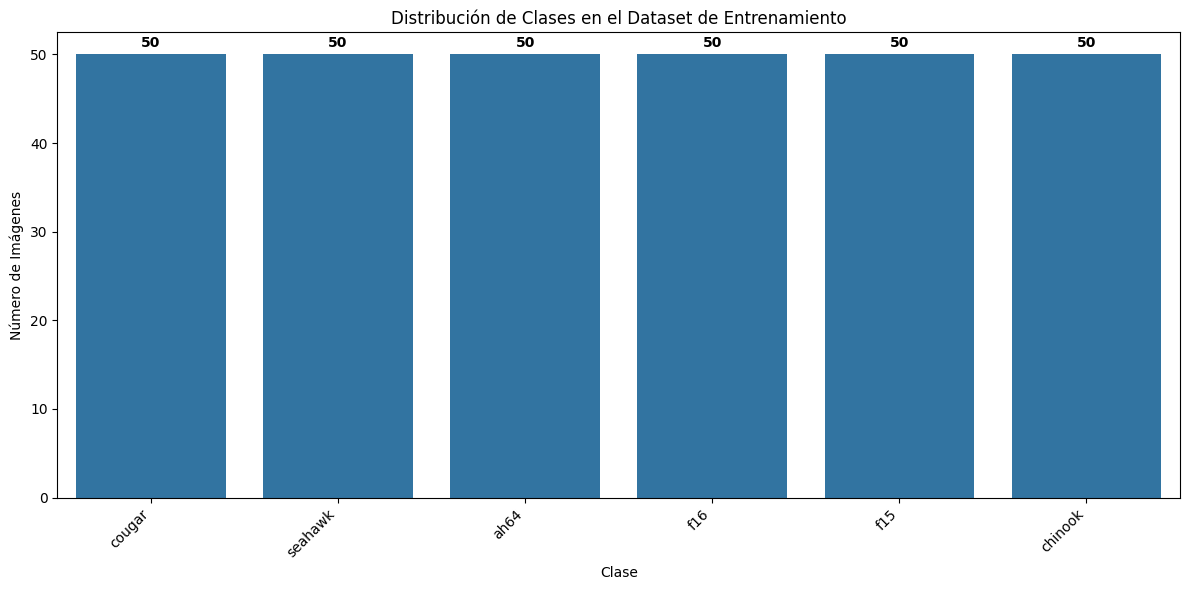

In [8]:
# Visualización del balance de clases
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values) # Store the axes object
plt.title('Distribución de Clases en el Dataset de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje x si hay muchas clases

# Mostrar los valores del numero de imagenes en cada una de las barras
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 0.5, str(v), color='black', ha='center', va='bottom', fontweight='bold')

plt.tight_layout() # Ajustar layout para que las etiquetas no se corten
plt.show()

In [9]:
# Determinar el número de clases y mapeos (índice <-> clase)
unique_classes = sorted(df_train['class'].unique())
num_classes = len(unique_classes)
class_to_idx = {cls_name: i for i, cls_name in enumerate(unique_classes)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}

print(f"\nNúmero total de clases únicas: {num_classes}")
print(f"Mapeo Clase a Índice: {class_to_idx}")
print(f"Mapeo Índice a Clase: {idx_to_class}")


Número total de clases únicas: 6
Mapeo Clase a Índice: {'ah64': 0, 'chinook': 1, 'cougar': 2, 'f15': 3, 'f16': 4, 'seahawk': 5}
Mapeo Índice a Clase: {0: 'ah64', 1: 'chinook', 2: 'cougar', 3: 'f15', 4: 'f16', 5: 'seahawk'}


## Parametros

In [10]:
# Definir el tamaño del lote (Batch Size). CRUCIAL para el uso de VRAM.
# Un tamaño más grande puede acelerar el entrenamiento pero consume más VRAM.
# Ajusta este valor según la memoria de tu GPU (8GB es limitado, empieza con 32 o 64).

# num_workers: Número de subprocesos para cargar datos. 0 significa que la carga es en el hilo principal.
# Para un notebook simple o depuración, 0 es aceptable. Para rendimiento en entrenamiento, usar > 0 es mejor,
# pero puede causar problemas en algunos entornos Jupyter (especialmente en Windows).
# Empieza con 0 y aumenta si necesitas más velocidad de carga.

BATCH_SIZE = 32 
IMG_HEIGHT, IMG_WIDTH = 255, 400
NUM_WORKERS = 0 

print(f"\nTamaño seleccionado para redimensionamiento: {IMG_HEIGHT}x{IMG_WIDTH} (Height x Width)")


Tamaño seleccionado para redimensionamiento: 255x400 (Height x Width)


Este tamaño seleccionado se debe a que es el mismo tamano de imagen que usaremos como backbone en la transferencia de conocimiento

## Preprocesamiento de Datos y Creación de DataLoaders

### División de dataframes

In [11]:
# Primero, dividir en train (70%) y temp (30%)
df_train_split, df_temp = train_test_split(
    df_train,
    test_size=0.3, # 30% para temp (val + test)
    random_state=42, # Para reproducibilidad
    stratify=df_train['class'] # Estratificar por clase para mantener el balance
)

# Luego, dividir temp (30%) en validación (15%) y prueba (15%)
# test_size=0.5 porque es 0.5 del 30% original, lo que da 15% del total
df_val_split, df_test_split = train_test_split(
    df_temp,
    test_size=0.5, # 50% de temp para test (10% del total)
    random_state=42, # Para reproducibilidad
    stratify=df_temp['class'] # Estratificar nuevamente
)

print(f"\nDimensiones de los DataFrames divididos:")
print(f"  Entrenamiento: {df_train_split.shape}")
print(f"  Validación: {df_val_split.shape}")
print(f"  Prueba: {df_test_split.shape}")


Dimensiones de los DataFrames divididos:
  Entrenamiento: (210, 8)
  Validación: (45, 8)
  Prueba: (45, 8)


In [12]:
# Creación de un Dataset Personalizado
class CustomImageDataset(torch.utils.data.Dataset):
    """Dataset personalizado para cargar imágenes desde un DataFrame y aplicar transformaciones."""

    def __init__(self, dataframe, img_dir, class_to_idx, transform=None):
        """
        Inicializa el Dataset.
        Args:
            dataframe (pandas.DataFrame): DataFrame con 'filename' y 'class'.
            img_dir (str): Directorio donde se encuentran todas las imágenes.
            class_to_idx (dict): Mapeo de nombres de clase a índices.
            transform (callable, optional): Transformaciones a aplicar.
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        # Mapear las etiquetas de clase de string a índice numérico
        self.label_indices = [self.class_to_idx[label] for label in self.img_labels['class']]

    def __len__(self):
        """Devuelve el número total de muestras en el dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Carga una muestra individual (imagen y etiqueta) por índice.
        Args:
            idx (int): Índice de la muestra.
        Returns:
            tuple: (imagen (Tensor), etiqueta (Tensor))
        """
        # Construir la ruta completa de la imagen
        img_name = self.img_labels.iloc[idx, 0] # Asumiendo 'filename' es la primera columna
        img_path = os.path.join(self.img_dir, img_name)

        try:
            # Abrir la imagen
            image = Image.open(img_path).convert('RGB') # Asegurar 3 canales RGB

            # Obtener la etiqueta y convertirla a tensor
            # label_name = self.img_labels.iloc[idx, 1] # Asumiendo 'class' es la segunda columna
            # label = torch.tensor(self.class_to_idx[label_name], dtype=torch.long)
            # Ya pre-calculamos los índices en __init__ para mayor eficiencia
            label = torch.tensor(self.label_indices[idx], dtype=torch.long)

            # Aplicar transformaciones si existen
            if self.transform:
                image = self.transform(image)

            return image, label

        except FileNotFoundError:
             print(f"Advertencia: Imagen no encontrada, saltando: {img_path}")
             return None, None 

        except Exception as e:
            print(f"Error al cargar o transformar la imagen {img_path}: {e}, saltando.")
            return None, None


print("Clase CustomImageDataset definida.")

Clase CustomImageDataset definida.


In [ ]:
#Calculo de media y desviación estándar de los valores RGB de las imágenes


base_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

dataset = CustomImageDataset(
    dataframe=df_train,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=base_transform
)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Acumular sumas y sumas de cuadrados
n_images = 0
sum_channels = torch.zeros(3)
sum_sq_channels = torch.zeros(3)

for imgs, _ in loader:
    n_batch = imgs.size(0)
    # imgs: [batch, 3, H, W]
    imgs = imgs.view(n_batch, 3, -1)  # [batch, 3, H*W]
    sum_channels += imgs.mean(dim=[0,2]) * n_batch
    sum_sq_channels += (imgs ** 2).mean(dim=[0,2]) * n_batch
    n_images += n_batch

# Media por canal
mean = sum_channels / n_images
# Varianza y luego std
var  = sum_sq_channels / n_images - mean**2
std  = torch.sqrt(var)

mean_list = mean.tolist()
std_list = std.tolist()

print("mean =", mean_list)
print("std  =", std_list)

mean = [0.528589129447937, 0.5788546204566956, 0.6231197714805603]
std  = [0.24197205901145935, 0.24344542622566223, 0.27202919125556946]


In [14]:
# Definición de Transformaciones de Preprocesamiento Estándar
# Estas transformaciones se aplicarán a los conjuntos de validación y prueba.

# Definir las transformaciones básicas: redimensionar, convertir a tensor, normalizar.
# La normalización utiliza la media y desviación estándar calculadas anteriormente.
# Para mayor precisión, deberías calcular la media/std de TU dataset de entrenamiento.
standard_transforms = transforms.Compose([    
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),    
    transforms.ToTensor(),    
    transforms.Normalize(mean=mean_list, std=std_list)
])

### Instanciación de Datasets

In [15]:
# Creamos instancias de nuestro Dataset para cada conjunto (train, val, test).
# Nota: train_dataset usará standard_transforms por ahora. Se actualizará más adelante.
train_dataset = CustomImageDataset(
    dataframe=df_train_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Usamos standard por ahora
)

val_dataset = CustomImageDataset(
    dataframe=df_val_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Validación usa transformaciones estándar (sin aumento)
)

test_dataset = CustomImageDataset(
    dataframe=df_test_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Prueba usa transformaciones estándar (sin aumento)
)

print(f"\nDatasets instanciados:")
print(f"  Entrenamiento: {len(train_dataset)} muestras")
print(f"  Validación: {len(val_dataset)} muestras")
print(f"  Prueba: {len(test_dataset)} muestras")



Datasets instanciados:
  Entrenamiento: 210 muestras
  Validación: 45 muestras
  Prueba: 45 muestras


### Batch Size

In [16]:
print(f"\nConfiguración de DataLoaders:")
print(f"  Tamaño del lote (BATCH_SIZE): {BATCH_SIZE}")
print(f"  Número de workers (NUM_WORKERS): {NUM_WORKERS}")


Configuración de DataLoaders:
  Tamaño del lote (BATCH_SIZE): 32
  Número de workers (NUM_WORKERS): 0


### Creación de DataLoaders

In [ ]:
# Creación de DataLoaders
# Los DataLoaders permiten iterar sobre el dataset en lotes.
print(f'Dispositivo seleccionado:{device.type}')
# Instanciar los DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Importante para entrenamiento: barajar los datos en cada época
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False # Copia datos a la memoria fija del host, útil para GPU
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la validación
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la prueba
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print("\nDataLoaders creados: train_loader, val_loader, test_loader")

Dispositivo seleccionado:cuda

DataLoaders creados: train_loader, val_loader, test_loader


In [18]:
# Verificación Rápida de un Lote
# Tomamos un lote de ejemplo para verificar las dimensiones y el dispositivo
try:
    # Obtener un iterador para el DataLoader
    data_iter = iter(train_loader)
    # Obtener el primer lote
    images, labels = next(data_iter)

    print(f"\nVerificación de un lote del train_loader:")
    print(f"  Dimensiones de las imágenes en el lote: {images.shape}") # Esperado: [BATCH_SIZE, Canales, Altura, Ancho]
    print(f"  Tipo de dato de las imágenes: {images.dtype}")
    print(f"  Dimensiones de las etiquetas en el lote: {labels.shape}") # Esperado: [BATCH_SIZE]
    print(f"  Tipo de dato de las etiquetas: {labels.dtype}")
    print(f"  Valores de las primeras 10 etiquetas: {labels[:10]}")
    print(f"  Rango de valores de píxeles (normalizados): min={images.min().item():.4f}, max={images.max().item():.4f}")

    # Mover un lote al dispositivo seleccionado (GPU si es posible) para probar
    images = images.to(device)
    labels = labels.to(device)
    print(f"  Dispositivo de las imágenes después de mover: {images.device}")
    print(f"  Dispositivo de las etiquetas después de mover: {labels.device}")

    # Liberar tensores de prueba para no consumir VRAM innecesariamente
    del images, labels
    # Limpiar caché de VRAM
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Lote de prueba cargado y verificado. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar cargar un lote de prueba: {e}")
    print("Asegúrate de que las rutas y el DataFrame son correctos y que hay imágenes válidas.")


# Limpieza de memoria 
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()



Verificación de un lote del train_loader:
  Dimensiones de las imágenes en el lote: torch.Size([32, 3, 255, 400])
  Tipo de dato de las imágenes: torch.float32
  Dimensiones de las etiquetas en el lote: torch.Size([32])
  Tipo de dato de las etiquetas: torch.int64
  Valores de las primeras 10 etiquetas: tensor([1, 1, 1, 1, 4, 1, 4, 0, 2, 2])
  Rango de valores de píxeles (normalizados): min=-2.3778, max=1.9482
  Dispositivo de las imágenes después de mover: cuda:0
  Dispositivo de las etiquetas después de mover: cuda:0
Lote de prueba cargado y verificado. Tensores liberados.


### Técnicas de Aumento de Datos (Data Augmentation)

In [19]:
print(f"\nUsando tamaño de imagen para augmentation: ({IMG_HEIGHT}x{IMG_WIDTH})")


Usando tamaño de imagen para augmentation: (255x400)


In [20]:
# Estas transformaciones incluyen el preprocesamiento estándar MÁS técnicas de aumento.

train_transforms = transforms.Compose([
    # Aumento: Recorta aleatoriamente y redimensiona a IMG_HEIGHT x IMG_WIDTH.
    # Scale es el rango del tamaño del recorte respecto al tamaño original.
    # Ratio es el rango de la relación de aspecto del recorte.
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # Aumento: Voltea horizontalmente la imagen con una probabilidad p=0.5.
    transforms.RandomHorizontalFlip(p=0.5),

    # Aumento: Ajustes aleatorios de brillo, contraste, saturación y matiz.
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),

    # Aumento: Rotación aleatoria. Degrees es el rango de ángulos.
    transforms.RandomRotation(degrees=10),

    # Convertir a tensor (como en standard_transforms)
    transforms.ToTensor(),

    # Normalizar (como en standard_transforms) 
    transforms.Normalize(mean=mean_list, std=std_list)    
])

print("\nTransformaciones con aumento de datos para entrenamiento definidas.")

# Las transformaciones para validación y prueba siguen siendo las estándar sin aumento

# Re-instanciar el Dataset de Entrenamiento con las Nuevas Transformaciones
# Solo cambiamos el argumento 'transform'.
train_dataset = CustomImageDataset(
    dataframe=df_train_split, # Usamos el mismo split de entrenamiento del MÓDULO 2
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=train_transforms # ¡Ahora usamos las transformaciones con aumento!
)

print(f"\nDataset de entrenamiento actualizado para usar aumento de datos: {len(train_dataset)} muestras.")
# Los datasets de validación y prueba (val_dataset, test_dataset) NO se modifican.

# Re-crear el DataLoader de Entrenamiento
# Re-creamos el DataLoader de entrenamiento usando el dataset actualizado.
# Mantenemos la misma configuración de BATCH_SIZE y NUM_WORKERS.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Seguir barajando el conjunto de entrenamiento
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False # Copia a memoria fija del host, esto permite transferencias de datos más rápidas y eficientes a la GPU.
)

print(f"DataLoader de entrenamiento re-creado con BATCH_SIZE={BATCH_SIZE} y NUM_WORKERS={NUM_WORKERS}.")
# Los DataLoaders de validación y prueba (val_loader, test_loader) NO se modifican.


Transformaciones con aumento de datos para entrenamiento definidas.

Dataset de entrenamiento actualizado para usar aumento de datos: 210 muestras.
DataLoader de entrenamiento re-creado con BATCH_SIZE=32 y NUM_WORKERS=0.


### Visualización del Efecto del Aumento de Datos


Visualizando un lote de imágenes con aumento de datos (muestra)...


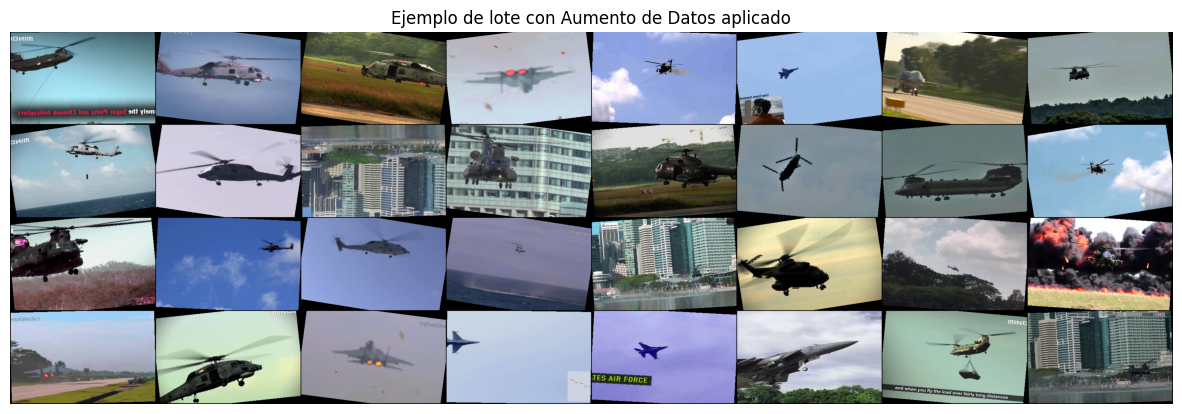

Etiquetas para el lote mostrado: [1, 5, 5, 3, 0, 3, 4, 1, 5, 5, 1, 1, 2, 1, 1, 0, 1, 0, 5, 5, 1, 2, 2, 0, 3, 5, 3, 4, 4, 3, 1, 1]
Visualización completada. Tensores liberados.


In [ ]:

# Para entender visualmente qué hacen las transformaciones de aumento.
print("\nVisualizando un lote de imágenes con aumento de datos (muestra)...")
try:
    # Tomar un lote de ejemplo del NUEVO train_loader
    images, labels = next(iter(train_loader))

    # Las imágenes ya están normalizadas. Para visualizarlas correctamente,
    # necesitamos "de-normalizarlas" (aplicar la inversa de la normalización).
    mean = torch.tensor(mean_list).view(1, 3, 1, 1) # (1, 3, 1, 1) para broadcasting
    std = torch.tensor(std_list).view(1, 3, 1, 1) # (1, 3, 1, 1) para broadcasting


    # De-normalizar: imagen = imagen * std + media
    # Clonar para no modificar el tensor original que podríamos usar después
    images_display = images * std + mean
    images_display = torch.clamp(images_display, 0, 1) # Asegurar que los valores estén en [0, 1]

    # Usar make_grid para crear una cuadrícula de imágenes
    grid = torchvision.utils.make_grid(images_display, nrow=8, padding=2) # nrow: imágenes por fila

    # Convertir el tensor de la cuadrícula a formato (H, W, C) para matplotlib
    plt.figure(figsize=(15, (BATCH_SIZE // 8) * 2)) # Ajusta el tamaño de la figura
    plt.imshow(grid.permute(1, 2, 0)) # Permuta las dimensiones para (H, W, C)
    plt.title("Ejemplo de lote con Aumento de Datos aplicado")
    plt.axis('off') # Ocultar ejes
    plt.show()

    # Mostrar las etiquetas de este lote
    print(f"Etiquetas para el lote mostrado: {labels.tolist()}")
    # Opcionalmente, mapear a nombres de clase si quieres:
    # label_names = [idx_to_class[l.item()] for l in labels]
    # print(f"Nombres de clase: {label_names}")


    # Liberar tensores de visualización
    del images, labels, images_display, grid, mean, std
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Visualización completada. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar visualizar un lote con aumento de datos: {e}")
    print("Asegúrate de que el DataLoader funciona y matplotlib/torchvision están correctamente instalados.")


# Limpieza de memoria opcional
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

## Definición de la Arquitectura CNN

In [22]:
print(f"\nDispositivo para el modelo: {device}")
print(f"Número de clases para la capa de salida: {num_classes}")
# IMG_HEIGHT, IMG_WIDTH también son relevantes, aunque la arquitectura simple
# puede ser un poco agnóstica al tamaño exacto antes de las capas lineales.


Dispositivo para el modelo: cuda
Número de clases para la capa de salida: 6


In [23]:
# Definición de la Clase del Modelo CNN
# Heredamos de nn.Module, la clase base para todos los módulos de redes neuronales en PyTorch.

   # Para tunear el dropout, SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate)
    # y dentro de SimpleCNN.__init__ self.dropout = nn.Dropout(p=dropout_rate)

class SimpleCNN(nn.Module):
    """
    Una arquitectura CNN para clasificación de imágenes.
    Consiste en capas convolucionales seguidas de capas totalmente conectadas.
    """
    def __init__(self, num_classes, dropout_rate=0.5):
        """
        Inicializa el modelo CNN.
        Args:
            num_classes (int): El número de clases de salida para la capa final.
            dropout_rate (float): Tasa de dropout para regularización.
        """
        super(SimpleCNN, self).__init__() # Llamar al constructor de la clase base

        # Definir las capas convolucionales y de pooling
        # Conv2d(canales_entrada, canales_salida, tamaño_kernel, stride, padding)
        # MaxPool2d(tamaño_kernel, stride, padding)

        # Primera capa convolucional
        # Entrada: 3 canales (RGB), Tamaño: IMG_HEIGHT x IMG_WIDTH 
        # Salida: 16 canales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # nn.BatchNorm2d ayuda a estabilizar y acelerar el entrenamiento
        self.bn1 = nn.BatchNorm2d(16)

        # Max Pooling: reduce las dimensiones espaciales
        # Tamaño de salida después de conv1 y pool1: (H/2) x (W/2) con 16 canales
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        # Entrada: 16 canales (salida de conv1/pool1)
        # Salida: 32 canales
        # Tamaño de salida después de conv2 y pool2: ((H/2)/2) x ((W/2)/2) = (H/4) x (W/4) con 32 canales
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Tercera capa convolucional
        # Entrada: 32 canales (salida de conv2/pool2)
        # Salida: 64 canales
        # Tamaño de salida después de conv3 y pool3: ((H/4)/2) x ((W/4)/2) = (H/8) x (W/8) con 64 canales
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Calcular el tamaño de la entrada a la primera capa lineal (Flatten)
        # Para un tamaño de entrada (H, W) y 3 capas con kernel_size=3, stride=1, padding=1, y pool_size=2, stride=2:
        # Tamaño de salida después de 3 pools es aproximadamente (H/8) x (W/8)        
        final_h = IMG_HEIGHT // 8
        final_w = IMG_WIDTH // 8
        linear_input_features = 64 * final_h * final_w # Canales_ultima_conv * Altura_final * Ancho_final
        print(f"Tamaño de entrada calculado para la capa lineal: {linear_input_features}")

        # Verificar que el tamaño de imagen es suficiente para 3 capas de pooling        
        if final_h < 1 or final_w < 1:
             raise ValueError(f"El tamaño de imagen ({IMG_HEIGHT}x{IMG_WIDTH}) es demasiado pequeño para 3 capas de pooling.")

        # Definir las capas totalmente conectadas (Fully Connected - FC)
        # La primera capa FC toma la salida aplanada de las capas convolucionales.
        self.fc1 = nn.Linear(in_features=linear_input_features, out_features=128)
        self.bn4 = nn.BatchNorm1d(128) # BatchNorm después de la lineal y antes de la activación

        # Capa de Dropout para regularización (ayuda a prevenir el sobreajuste)
        #self.dropout = nn.Dropout(p=0.5)
        self.dropout = nn.Dropout(p=dropout_rate) # Tasa de dropout ajustable
        # La capa final FC tiene el número de neuronas igual al número de clases.
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)


    def forward(self, x):
        """
        Define el pase hacia adelante (forward pass) del modelo.
        Define cómo los datos fluyen a través de las capas.
        """
        # Aplicar capas convolucionales, BatchNorm, activación ReLU y Pooling
        # (Canales_entrada, H, W) -> (Canales_salida_conv1, H/2, W/2)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # (Canales_salida_conv1, H/2, W/2) -> (Canales_salida_conv2, H/4, W/4)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # (Canales_salida_conv2, H/4, W/4) -> (Canales_salida_conv3, H/8, W/8)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Aplanar la salida de las capas convolucionales para pasarla a las capas FC
        # El "-1" en view() infiere automáticamente el tamaño del lote
        # x.size(0) es el tamaño del lote
        # x.view(x.size(0), -1) aplana cada imagen en el lote en un vector 1D
        # La dimensión aplanada es linear_input_features (calculada en __init__)
        x = x.view(x.size(0), -1) # Equivalentemente: x = torch.flatten(x, 1)

        # Aplicar capas totalmente conectadas con activación ReLU y Dropout
        # -> (Tamaño_lote, 128)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        # -> (Tamaño_lote, num_classes) - Salida final (logits antes de softmax)
        x = self.fc2(x)

        return x # La salida son los logits, no las probabilidades (la función de pérdida maneja softmax)


# Instanciación del Modelo
# Creamos una instancia de nuestra clase CNNModel.
# Le pasamos el número de clases determinado anteriormente.
# Esto crea un objeto modelo que contiene todas las capas definidas en la clase.
model = SimpleCNN(num_classes=num_classes)

print("\nInstancia del modelo SimpleCNN creada.")

# Mover el Modelo al Dispositivo Seleccionado (GPU si es posible)
model.to(device)

print(f"Modelo movido al dispositivo: {device}")

# Mostrar la Estructura del Modelo
print("\nEstructura del modelo:")
print(model)


Tamaño de entrada calculado para la capa lineal: 99200

Instancia del modelo SimpleCNN creada.
Modelo movido al dispositivo: cuda

Estructura del modelo:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=99200, out_features=128, bias=True)
  (bn4): BatchNo

In [24]:
# Se puede usar la librería 'torchsummary' para un resumen más detallado si está instalada:
# !pip install torchsummary 
try:    
    # summary(model, input_size=(Canales, Altura, Ancho))    
    print("\nResumen del modelo (con torchsummary):")
    summary(model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))
except ImportError:
    print("\nInstala torchsummary (pip install torchsummary) para ver un resumen detallado del modelo.")
except Exception as e:
    print(f"\nError al generar resumen con torchsummary: {e}")
    print("Asegúrate de que el tamaño de entrada (3, IMG_HEIGHT, IMG_WIDTH) es correcto.")


Resumen del modelo (con torchsummary):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 400]             448
       BatchNorm2d-2         [-1, 16, 255, 400]              32
         MaxPool2d-3         [-1, 16, 127, 200]               0
            Conv2d-4         [-1, 32, 127, 200]           4,640
       BatchNorm2d-5         [-1, 32, 127, 200]              64
         MaxPool2d-6          [-1, 32, 63, 100]               0
            Conv2d-7          [-1, 64, 63, 100]          18,496
       BatchNorm2d-8          [-1, 64, 63, 100]             128
         MaxPool2d-9           [-1, 64, 31, 50]               0
           Linear-10                  [-1, 128]      12,697,728
      BatchNorm1d-11                  [-1, 128]             256
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 6]             774

In [25]:
# Limpieza de memoria 
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

## Entrenamiento para Optimización (Objective Function)

In [26]:
print(f"\nComponentes disponibles para la función objetivo:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Clase del modelo: {SimpleCNN.__name__}") # Verificamos que la clase SimpleCNN está definida


Componentes disponibles para la función objetivo:
  Dispositivo: cuda
  DataLoaders: train_loader (210 muestras), val_loader (45 muestras)
  Número de clases: 6
  Clase del modelo: SimpleCNN


In [27]:
n_trials = 60 # 10 Número de pruebas (combinaciones de HPs) a intentar. 
num_epochs_trial = 100 # Número de épocas para cada prueba.               
patience = 50 # Paciencia para Early Stopping DENTRO de cada prueba de Optuna

In [28]:
# Definición de la Función de Entrenamiento para Optimización (Objective Function)

# Definición de la Función Objetivo para Optuna
def objective(trial, train_loader, val_loader, device, num_classes, checkpoint_dir='./optuna_checkpoints'):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.
    Entrena y valida un modelo con los hiperparámetros sugeridos por 'trial'.

    Args:
        trial (optuna.Trial): Objeto Trial proporcionado por Optuna para sugerir HPs y reportar métricas.
        train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
        val_loader (DataLoader): DataLoader para el conjunto de validación.
        device (torch.device): Dispositivo (CPU/GPU) para entrenar.
        num_classes (int): Número de clases de salida.
        checkpoint_dir (str): Directorio base para guardar checkpoints de las pruebas.

    Returns:
        float: La métrica de validación a maximizar (por ejemplo, precisión de validación).
              Optuna intenta maximizar/minimizar este valor.
    """
    print(f"\n--- Iniciando Prueba Optuna #{trial.number} de {num_epochs_trial} ---")

    # --- Sugerir Hiperparámetros ---
    # Optuna llama a trial.suggest_... para obtener un valor para un hiperparámetro.
    # El nombre (ej. 'learning_rate') identifica el hiperparámetro.
    # Los argumentos siguientes definen el rango o las opciones a explorar.

    # Tasa de aprendizaje (escala logarítmica es común para LR)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Factor de weight decay (regularización L2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Tasa de dropout
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.8) # Rango entre 20% y 80%

    # Elección del optimizador 
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD","AdamW"])

    # Si el optimizador es SGD, sugerir un valor de momentum
    # (momentum es un hiperparámetro común para SGD, no para Adam)
    momentum = trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else None

    # Si el optimizador es AdamW, sugerir un valor de betas y weight_decay específico
    if optimizer_name == "AdamW":
        # AdamW puede tener weight_decay más alto que Adam/SGD
        weight_decay = trial.suggest_float("adamw_weight_decay", 1e-5, 1e-2, log=True)

    print(f"  Hiperparámetros sugeridos:")
    print(f"    Learning Rate: {lr:.6f}")
    print(f"    Weight Decay: {weight_decay:.6f}")
    print(f"    Dropout Rate: {dropout_rate:.2f}")
    if optimizer_name == "SGD": print(f"    Optimizer: {optimizer_name}, Momentum: {momentum:.2f}")
    else: print(f"    Optimizer: {optimizer_name}")


    # --- Configurar Modelo, Función de Pérdida y Optimizador ---
    # Re-instanciar el modelo para cada prueba para asegurar un estado limpio    
    model = SimpleCNN(num_classes=num_classes) # Re-instanciar

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout_rate # Ajusta la tasa de dropout sugerida por Optuna
            print(f"    Ajustada tasa de dropout en el modelo a: {dropout_rate:.2f}")


    model.to(device) # Mover el modelo al dispositivo

    criterion = nn.CrossEntropyLoss() # Función de pérdida 

    # Configurar el optimizador con los HPs sugeridos
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        
    # --- Bucle de Entrenamiento y Validación  ---    
    epochs_since_last_improvement = 0
    best_val_loss = float('inf') # Inicializar la mejor pérdida de validación

    # Para guardar el estado del mejor modelo *de esta prueba*
    best_model_state = None
    best_optimizer_state = None    

    for epoch in range(num_epochs_trial):
        
        print(f"\nTrial {trial.number} Época {epoch+1}/{num_epochs_trial}:")
        # Entrenamiento
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train_preds += labels.size(0)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct_train_preds / total_train_preds        

        # Validación
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val_preds += labels.size(0)
                correct_val_preds += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct_val_preds / total_val_preds

        print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
        print(f'epoch_val_loss  : {epoch_val_loss:.4f}, epoch_val_accuracy  : {epoch_val_accuracy:.2f}%')

        # Checkpointing (dentro del trial) y Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_since_last_improvement = 0
            # Guardar el estado del mejor modelo *de esta prueba*
            best_model_state = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            print(f"    Mejora en Prueba #{trial.number}, Época {epoch+1}. loss: {best_val_loss} Precisión: {epoch_val_accuracy:.2f}%") 

        else:
            epochs_since_last_improvement += 1
            print(f"    Sin mejora en Prueba #{trial.number}, Época {epoch+1}. Paciencia: {epochs_since_last_improvement}/{patience}") 

        # Reportar métrica intermedia a Optuna (puedes reportar pérdida, precisión, etc.)
        # Esto permite a Optuna podar (detener) pruebas que no parecen prometedoras.
        # Optuna espera la métrica que está optimizando.
        trial.report(epoch_val_loss, epoch)

        # Verificar si la prueba debe ser podada por Optuna
        if trial.should_prune():
            print(f"  Prueba #{trial.number} podada en la Época {epoch+1} (loss {epoch_val_loss} precisión {epoch_val_accuracy:.2f}%).")
            raise optuna.exceptions.TrialPruned()

        # Early Stopping Check (basado en la paciencia dentro de la prueba)
        if epochs_since_last_improvement >= patience:
            print(f"  Early stopping para Prueba #{trial.number}. No hubo mejora en {patience} épocas.")
            break # Salir del bucle de entrenamiento de la prueba

        # Limpieza de VRAM en cada época del trial
        if device.type == 'cuda':
             torch.cuda.empty_cache() 

    print(f"--- Prueba Optuna #{trial.number} Finalizada. Mejor loss de Validación: {best_val_loss} ---")
    
    trial_checkpoint_path = os.path.join(checkpoint_dir, f'trial_{trial.number}_best_checkpoint.pth')
    torch.save({
         'model_state_dict': best_model_state,
         'optimizer_state_dict': best_optimizer_state, 
         'best_val_loss': best_val_loss,         
         'hps': trial.params
    }, trial_checkpoint_path)
    print(f"  Mejor checkpoint de Prueba #{trial.number} guardado en: {trial_checkpoint_path}")

    # Limpiar memoria después de cada trial
    del model, optimizer, criterion # scheduler es más ligero
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de la limpieza del trial: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    # La función objetivo DEBE retornar el valor a optimizar
    return best_val_loss 

print("\nFunción 'objective' definida. Lista para ser utilizada por Optuna.")



Función 'objective' definida. Lista para ser utilizada por Optuna.


### Optimización de Hiperparámetros (usando Optuna)

In [29]:
# MÓDULO 6: Optimización de Hiperparámetros (usando Optuna)

# Asegurarse de que la función 'objective' y las variables necesarias estén disponibles
if 'objective' not in locals() or 'train_loader' not in locals() or 'val_loader' not in locals() or 'device' not in locals() or 'num_classes' not in locals() or 'SimpleCNN' not in locals() or 'class_to_idx' not in locals():
     print("Error: La función 'objective' o variables de módulos anteriores no encontradas.")
     print("Asegúrate de ejecutar los MÓDULOS 1, 2 (con M3), 4 y 5 primero.")
     raise RuntimeError("Faltan componentes necesarios para ejecutar el estudio de Optuna.")

print(f"\nComponentes disponibles para el estudio Optuna:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Mapeo clase a índice disponible.")
print(f"  Clase del modelo: {SimpleCNN.__name__}")
print(f"  Función objetivo 'objective' definida.")


# --- Configuración del Estudio de Optuna ---
# Define el directorio para los checkpoints de Optuna si quieres guardar el mejor modelo de cada prueba (opcional, solo el mejor general es clave)
# solo re-entrenaremos y guardaremos el modelo final con los mejores HPs.
OPTUNA_CHECKPOINT_BASE_DIR = './Optuna/optuna_trial_checkpoints'
os.makedirs(OPTUNA_CHECKPOINT_BASE_DIR, exist_ok=True)

# Crear un estudio de Optuna
# study_name: Nombre del estudio (útil si usas una base de datos)
# storage: Dónde guardar los resultados. 'sqlite:///example.db' usa una base de datos SQLite. None = en memoria (se pierden resultados al cerrar notebook).
# direction: 'maximize' para maximizar la métrica (ej. precisión), 'minimize' si se quiere minimizar (ej. pérdida).
study = optuna.create_study(study_name="image_classification_hptuning",
                            storage=None, # Usar None para estudio en memoria simple en notebook
                            direction="minimize", # Queremos minimizar el valor de loss
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
                            # Corta los ensayos que rinden por debajo de la mediana de los anteriores
                            # n_startup_trials=5: no se poda en las primeras 5 pruebas.
                            #n_warmup_steps=2: no se poda antes de la época 2. 
                        ) 

print(f"\nEjecutando estudio de Optuna con {n_trials} pruebas...")

try:
    # Pasar argumentos fijos a la función objetivo usando lambda
    # La función lambda toma el objeto trial y llama a la función objective con los otros argumentos fijos.
    # Si decidieras guardar checkpoints por trial, pasarías OPTUNA_CHECKPOINT_BASE_DIR aquí.
    study.optimize(lambda trial: objective(trial, train_loader, val_loader, device, num_classes,checkpoint_dir=OPTUNA_CHECKPOINT_BASE_DIR),
                   n_trials=n_trials,
                   gc_after_trial=True) # Forzar la recolección de basura después de cada trial (ayuda con memoria)

except Exception as e:
    print(f"\n¡Error durante el estudio de Optuna!: {e}")
    print("El estudio se detuvo prematuramente. Puedes inspeccionar los resultados hasta ahora.")

print("\nEstudio de Optuna completado.")

[I 2025-05-25 13:00:23,525] A new study created in memory with name: image_classification_hptuning



Componentes disponibles para el estudio Optuna:
  Dispositivo: cuda
  DataLoaders: train_loader (210 muestras), val_loader (45 muestras)
  Número de clases: 6
  Mapeo clase a índice disponible.
  Clase del modelo: SimpleCNN
  Función objetivo 'objective' definida.

Ejecutando estudio de Optuna con 60 pruebas...

--- Iniciando Prueba Optuna #0 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000419
    Weight Decay: 0.000026
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 0 Época 1/100:
epoch_train_loss: 1.6988, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7421, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #0, Época 1. loss: 1.7421378559536405 Precisión: 35.56%

Trial 0 Época 2/100:
epoch_train_loss: 1.3541, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6978, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #0, Época 2. loss: 1.6978073120117188 Precisión: 

[I 2025-05-25 13:05:45,212] Trial 0 finished with value: 0.961997840139601 and parameters: {'learning_rate': 0.00041911199311056, 'weight_decay': 2.581474647260134e-05, 'dropout_rate': 0.289607268498357, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #1 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000030
    Weight Decay: 0.000229
    Dropout Rate: 0.52
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 1 Época 1/100:
epoch_train_loss: 1.7386, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7598, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #1, Época 1. loss: 1.7597734663221571 Precisión: 15.56%

Trial 1 Época 2/100:
epoch_train_loss: 1.3858, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6894, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #1, Época 2. loss: 1.6894386768341065 Precisión: 31.11%

Trial 1 Época 3/100:
epoch_train_loss: 1.2544, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.5884, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #1, Época 3. loss: 1.588397373093499 Precisión: 37.78%

Trial 1 Época 4/100:
epoch_train_loss: 1.1717, 

[I 2025-05-25 13:11:16,833] Trial 1 finished with value: 1.076429041226705 and parameters: {'learning_rate': 2.9613230117079782e-05, 'weight_decay': 0.00022869226500548895, 'dropout_rate': 0.5208475523133234, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #2 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.030415
    Weight Decay: 0.000004
    Dropout Rate: 0.52
    Optimizer: SGD, Momentum: 0.97
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 2 Época 1/100:
epoch_train_loss: 1.7946, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.6923, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #2, Época 1. loss: 1.6922640747494169 Precisión: 28.89%

Trial 2 Época 2/100:
epoch_train_loss: 1.6034, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.9015, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #2, Época 2. Paciencia: 1/50

Trial 2 Época 3/100:
epoch_train_loss: 1.6112, epoch_train_accuracy: 36.67%
epoch_val_loss  : 2.5957, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #2, Época 3. Paciencia: 2/50

Trial 2 Época 4/100:
epoch_train_loss: 1.6997, epoch_train_accuracy: 42.38%
e

[I 2025-05-25 13:15:31,476] Trial 2 finished with value: 1.1972307682037353 and parameters: {'learning_rate': 0.03041517206130491, 'weight_decay': 4.37598938906211e-06, 'dropout_rate': 0.5163174208547792, 'optimizer': 'SGD', 'momentum': 0.9663119662276987}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #3 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000223
    Weight Decay: 0.000009
    Dropout Rate: 0.76
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 3 Época 1/100:
epoch_train_loss: 2.0260, epoch_train_accuracy: 18.10%
epoch_val_loss  : 1.7947, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #3, Época 1. loss: 1.794747789700826 Precisión: 15.56%

Trial 3 Época 2/100:
epoch_train_loss: 1.7407, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7871, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #3, Época 2. loss: 1.7870563374625312 Precisión: 24.44%

Trial 3 Época 3/100:
epoch_train_loss: 1.5495, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.7408, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #3, Época 3. loss: 1.740808449851142 Precisión: 28.89%

Trial 3 Época 4/100:
epoch_train_

[I 2025-05-25 13:21:00,120] Trial 3 finished with value: 1.1409564892450967 and parameters: {'learning_rate': 0.00022343767803267923, 'weight_decay': 8.909614080900964e-06, 'dropout_rate': 0.7622048310467855, 'optimizer': 'SGD', 'momentum': 0.8442001201684243}. Best is trial 0 with value: 0.961997840139601.


epoch_train_loss: 0.4643, epoch_train_accuracy: 90.48%
epoch_val_loss  : 1.2013, epoch_val_accuracy  : 60.00%
    Sin mejora en Prueba #3, Época 100. Paciencia: 9/50
--- Prueba Optuna #3 Finalizada. Mejor loss de Validación: 1.1409564892450967 ---
  Mejor checkpoint de Prueba #3 guardado en: ./Optuna/optuna_trial_checkpoints\trial_3_best_checkpoint.pth
  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #4 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000255
    Weight Decay: 0.000974
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 4 Época 1/100:
epoch_train_loss: 1.7807, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7620, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #4, Época 1. loss: 1.7620049503114488 Precisión: 24.44%

Trial 4 Época 2/100:
epoch_train_loss: 1.4356, epoch_train_accuracy: 44.76%
epoch_val_loss  : 

[I 2025-05-25 13:26:23,797] Trial 4 finished with value: 1.0286366939544678 and parameters: {'learning_rate': 0.00025459524631910616, 'weight_decay': 0.0009735948510305787, 'dropout_rate': 0.2943459145606921, 'optimizer': 'SGD', 'momentum': 0.8913132386760024}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #5 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.019359
    Weight Decay: 0.000236
    Dropout Rate: 0.80
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.80

Trial 5 Época 1/100:
epoch_train_loss: 2.2025, epoch_train_accuracy: 18.57%
epoch_val_loss  : 7.4663, epoch_val_accuracy  : 8.89%
    Mejora en Prueba #5, Época 1. loss: 7.466305934058296 Precisión: 8.89%

Trial 5 Época 2/100:
epoch_train_loss: 2.1821, epoch_train_accuracy: 22.86%
epoch_val_loss  : 12.0559, epoch_val_accuracy  : 17.78%
    Sin mejora en Prueba #5, Época 2. Paciencia: 1/50

Trial 5 Época 3/100:


[I 2025-05-25 13:26:33,757] Trial 5 pruned. 


epoch_train_loss: 2.0862, epoch_train_accuracy: 24.29%
epoch_val_loss  : 4.1312, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #5, Época 3. loss: 4.131207275390625 Precisión: 17.78%
  Prueba #5 podada en la Época 3 (loss 4.131207275390625 precisión 17.78%).

--- Iniciando Prueba Optuna #6 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.026647
    Weight Decay: 0.000078
    Dropout Rate: 0.58
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 6 Época 1/100:
epoch_train_loss: 1.7655, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7805, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #6, Época 1. loss: 1.780484257804023 Precisión: 24.44%

Trial 6 Época 2/100:
epoch_train_loss: 1.6090, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7928, epoch_val_accuracy  : 26.67%
    Sin mejora en Prueba #6, Época 2. Paciencia: 1/50

Trial 6 Época 3/100:


[I 2025-05-25 13:26:43,702] Trial 6 pruned. 


epoch_train_loss: 1.4482, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.7990, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #6, Época 3. Paciencia: 2/50
  Prueba #6 podada en la Época 3 (loss 1.799025837580363 precisión 28.89%).

--- Iniciando Prueba Optuna #7 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002907
    Weight Decay: 0.000009
    Dropout Rate: 0.41
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.41

Trial 7 Época 1/100:
epoch_train_loss: 1.7742, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7298, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #7, Época 1. loss: 1.7297792355219523 Precisión: 26.67%

Trial 7 Época 2/100:
epoch_train_loss: 1.3868, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.6919, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #7, Época 2. loss: 1.6919157266616822 Precisión: 28.89%

Trial 7 Época 3/100:


[I 2025-05-25 13:26:53,811] Trial 7 pruned. 


epoch_train_loss: 1.3208, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6287, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #7, Época 3. loss: 1.6287209855185614 Precisión: 31.11%
  Prueba #7 podada en la Época 3 (loss 1.6287209855185614 precisión 31.11%).

--- Iniciando Prueba Optuna #8 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.070360
    Weight Decay: 0.000071
    Dropout Rate: 0.50
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.50

Trial 8 Época 1/100:
epoch_train_loss: 2.5449, epoch_train_accuracy: 14.29%
epoch_val_loss  : 45.9903, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #8, Época 1. loss: 45.99031660291884 Precisión: 17.78%

Trial 8 Época 2/100:
epoch_train_loss: 2.3199, epoch_train_accuracy: 23.33%
epoch_val_loss  : 7.3137, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #8, Época 2. loss: 7.31373422410753 Precisión: 15.56%

Trial 8 Época 3/100:


[I 2025-05-25 13:27:03,878] Trial 8 pruned. 


epoch_train_loss: 2.0225, epoch_train_accuracy: 25.71%
epoch_val_loss  : 3.2166, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #8, Época 3. loss: 3.2166097746955025 Precisión: 22.22%
  Prueba #8 podada en la Época 3 (loss 3.2166097746955025 precisión 22.22%).

--- Iniciando Prueba Optuna #9 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001694
    Weight Decay: 0.000042
    Dropout Rate: 0.57
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.57

Trial 9 Época 1/100:
epoch_train_loss: 1.8216, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7479, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #9, Época 1. loss: 1.7479281372494169 Precisión: 24.44%

Trial 9 Época 2/100:
epoch_train_loss: 1.5534, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7388, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #9, Época 2. loss: 1.7387550274531047 Precisión: 22.22%

Trial 9 Época 3/100:


[I 2025-05-25 13:27:13,856] Trial 9 pruned. 


epoch_train_loss: 1.3874, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.6886, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #9, Época 3. loss: 1.6885760333802966 Precisión: 24.44%
  Prueba #9 podada en la Época 3 (loss 1.6885760333802966 precisión 24.44%).

--- Iniciando Prueba Optuna #10 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000010
    Weight Decay: 0.001148
    Dropout Rate: 0.21
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 10 Época 1/100:
epoch_train_loss: 1.7138, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7591, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #10, Época 1. loss: 1.7590570370356242 Precisión: 24.44%

Trial 10 Época 2/100:
epoch_train_loss: 1.4249, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.7210, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #10, Época 2. loss: 1.7210409747229682 Precisión: 28.89%

Trial 10 Época 3/100:


[I 2025-05-25 13:27:23,963] Trial 10 pruned. 


epoch_train_loss: 1.2798, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6550, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #10, Época 3. loss: 1.655003555615743 Precisión: 31.11%
  Prueba #10 podada en la Época 3 (loss 1.655003555615743 precisión 31.11%).

--- Iniciando Prueba Optuna #11 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000216
    Weight Decay: 0.000012
    Dropout Rate: 0.24
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 11 Época 1/100:
epoch_train_loss: 1.7091, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7845, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #11, Época 1. loss: 1.7845222738054063 Precisión: 26.67%

Trial 11 Época 2/100:
epoch_train_loss: 1.3631, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.7443, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #11, Época 2. loss: 1.7442929320865208 Precisión: 22.22%

Trial 11 Época 3/100:


[I 2025-05-25 13:27:33,922] Trial 11 pruned. 


epoch_train_loss: 1.2321, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6541, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #11, Época 3. loss: 1.654124206966824 Precisión: 28.89%
  Prueba #11 podada en la Época 3 (loss 1.654124206966824 precisión 28.89%).

--- Iniciando Prueba Optuna #12 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000262
    Weight Decay: 0.000950
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 12 Época 1/100:
epoch_train_loss: 1.7028, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.8425, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #12, Época 1. loss: 1.8424673583772448 Precisión: 15.56%

Trial 12 Época 2/100:
epoch_train_loss: 1.4049, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.8808, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #12, Época 2. Paciencia: 1/50

Trial 12 Época 3/100:


[I 2025-05-25 13:27:43,925] Trial 12 pruned. 


epoch_train_loss: 1.2532, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.8140, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #12, Época 3. loss: 1.81397684680091 Precisión: 24.44%
  Prueba #12 podada en la Época 3 (loss 1.81397684680091 precisión 24.44%).

--- Iniciando Prueba Optuna #13 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000973
    Weight Decay: 0.000018
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 13 Época 1/100:
epoch_train_loss: 1.6903, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7425, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #13, Época 1. loss: 1.7424765321943494 Precisión: 22.22%

Trial 13 Época 2/100:
epoch_train_loss: 1.3645, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.6982, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #13, Época 2. loss: 1.6981526162889269 Precisión: 28.89%

Trial 13 Época 3/100:
epoch_train_loss:

[I 2025-05-25 13:27:57,180] Trial 13 pruned. 


epoch_train_loss: 1.2093, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.5546, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #13, Época 4. loss: 1.5546001566780938 Precisión: 35.56%
  Prueba #13 podada en la Época 4 (loss 1.5546001566780938 precisión 35.56%).

--- Iniciando Prueba Optuna #14 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000067
    Weight Decay: 0.009847
    Dropout Rate: 0.39
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 14 Época 1/100:
epoch_train_loss: 1.7292, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7535, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #14, Época 1. loss: 1.7534657345877753 Precisión: 24.44%

Trial 14 Época 2/100:
epoch_train_loss: 1.3098, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.7468, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #14, Época 2. loss: 1.7467966000239055 Precisión: 26.67%

Trial 14 Época 3/100:


[I 2025-05-25 13:28:07,310] Trial 14 pruned. 


epoch_train_loss: 1.2247, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.6645, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #14, Época 3. loss: 1.6645342005623711 Precisión: 35.56%
  Prueba #14 podada en la Época 3 (loss 1.6645342005623711 precisión 35.56%).

--- Iniciando Prueba Optuna #15 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004383
    Weight Decay: 0.000023
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 15 Época 1/100:
epoch_train_loss: 1.7094, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7204, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #15, Época 1. loss: 1.7203903516133627 Precisión: 31.11%

Trial 15 Época 2/100:
epoch_train_loss: 1.3568, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.6876, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #15, Época 2. loss: 1.6875964615080092 Precisión: 31.11%

Trial 15 Época 3/100

[I 2025-05-25 13:28:23,975] Trial 15 pruned. 


epoch_train_loss: 1.0554, epoch_train_accuracy: 63.81%
epoch_val_loss  : 1.4745, epoch_val_accuracy  : 48.89%
    Mejora en Prueba #15, Época 5. loss: 1.4745375421312121 Precisión: 48.89%
  Prueba #15 podada en la Época 5 (loss 1.4745375421312121 precisión 48.89%).

--- Iniciando Prueba Optuna #16 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000650
    Weight Decay: 0.000001
    Dropout Rate: 0.38
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 16 Época 1/100:
epoch_train_loss: 1.7990, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7235, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #16, Época 1. loss: 1.7235456387201944 Precisión: 24.44%

Trial 16 Época 2/100:
epoch_train_loss: 1.4581, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.6644, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #16, Época 2. loss: 1.664388116200765 Precisión: 40.00%

Trial 16 Época 3/100:
epoch_train_lo

[I 2025-05-25 13:28:40,735] Trial 16 pruned. 


epoch_train_loss: 1.1111, epoch_train_accuracy: 64.29%
epoch_val_loss  : 1.4217, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #16, Época 5. loss: 1.4216913011338976 Precisión: 46.67%
  Prueba #16 podada en la Época 5 (loss 1.4216913011338976 precisión 46.67%).

--- Iniciando Prueba Optuna #17 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000058
    Weight Decay: 0.000483
    Dropout Rate: 0.43
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 17 Época 1/100:
epoch_train_loss: 1.7254, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7537, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #17, Época 1. loss: 1.7536585887273153 Precisión: 22.22%

Trial 17 Época 2/100:
epoch_train_loss: 1.3335, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.6934, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #17, Época 2. loss: 1.6933749278386434 Precisión: 22.22%

Trial 17 Época 3/100:
epoch_train_l

[I 2025-05-25 13:28:57,381] Trial 17 pruned. 


epoch_train_loss: 1.0985, epoch_train_accuracy: 65.24%
epoch_val_loss  : 1.4280, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #17, Época 5. loss: 1.4280065483517117 Precisión: 51.11%
  Prueba #17 podada en la Época 5 (loss 1.4280065483517117 precisión 51.11%).

--- Iniciando Prueba Optuna #18 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005720
    Weight Decay: 0.000095
    Dropout Rate: 0.66
    Optimizer: SGD, Momentum: 0.98
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 18 Época 1/100:
epoch_train_loss: 1.8443, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.6873, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #18, Época 1. loss: 1.6872962368859186 Precisión: 28.89%

Trial 18 Época 2/100:
epoch_train_loss: 1.5424, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6132, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #18, Época 2. loss: 1.6131580220328436 Precisión: 31.11%

Trial 18 Época 3/100

[I 2025-05-25 13:29:10,727] Trial 18 pruned. 


epoch_train_loss: 1.4107, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6196, epoch_val_accuracy  : 40.00%
    Sin mejora en Prueba #18, Época 4. Paciencia: 1/50
  Prueba #18 podada en la Época 4 (loss 1.619564151763916 precisión 40.00%).

--- Iniciando Prueba Optuna #19 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000452
    Weight Decay: 0.000021
    Dropout Rate: 0.27
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 19 Época 1/100:
epoch_train_loss: 1.7299, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.8065, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #19, Época 1. loss: 1.8064858807457818 Precisión: 17.78%

Trial 19 Época 2/100:
epoch_train_loss: 1.3191, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7719, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #19, Época 2. loss: 1.7719486395517985 Precisión: 17.78%

Trial 19 Época 3/100:


[I 2025-05-25 13:29:20,769] Trial 19 pruned. 


epoch_train_loss: 1.2313, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.6656, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #19, Época 3. loss: 1.6655980481041803 Precisión: 26.67%
  Prueba #19 podada en la Época 3 (loss 1.6655980481041803 precisión 26.67%).

--- Iniciando Prueba Optuna #20 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000119
    Weight Decay: 0.000035
    Dropout Rate: 0.45
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.45

Trial 20 Época 1/100:
epoch_train_loss: 1.7950, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7255, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #20, Época 1. loss: 1.7255173100365533 Precisión: 28.89%

Trial 20 Época 2/100:
epoch_train_loss: 1.3723, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6849, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #20, Época 2. loss: 1.6849476443396674 Precisión: 40.00%

Trial 20 Época 3/100:


[I 2025-05-25 13:29:30,787] Trial 20 pruned. 


epoch_train_loss: 1.3206, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6357, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #20, Época 3. loss: 1.6357389794455635 Precisión: 35.56%
  Prueba #20 podada en la Época 3 (loss 1.6357389794455635 precisión 35.56%).

--- Iniciando Prueba Optuna #21 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000021
    Weight Decay: 0.000273
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 21 Época 1/100:
epoch_train_loss: 1.6802, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7629, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #21, Época 1. loss: 1.7629145357343885 Precisión: 17.78%

Trial 21 Época 2/100:
epoch_train_loss: 1.3440, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7514, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #21, Época 2. loss: 1.7514397011862861 Precisión: 17.78%

Trial 21 Época 3/100:


[I 2025-05-25 13:29:40,816] Trial 21 pruned. 


epoch_train_loss: 1.2286, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6401, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #21, Época 3. loss: 1.6401478396521674 Precisión: 26.67%
  Prueba #21 podada en la Época 3 (loss 1.6401478396521674 precisión 26.67%).

--- Iniciando Prueba Optuna #22 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000023
    Weight Decay: 0.000448
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 22 Época 1/100:
epoch_train_loss: 1.8030, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7419, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #22, Época 1. loss: 1.7418986876805624 Precisión: 22.22%

Trial 22 Época 2/100:
epoch_train_loss: 1.3882, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.7067, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #22, Época 2. loss: 1.7067240556081136 Precisión: 24.44%

Trial 22 Época 3/100:
epoch_train_l

[I 2025-05-25 13:30:00,659] Trial 22 pruned. 


epoch_train_loss: 1.1201, epoch_train_accuracy: 62.86%
epoch_val_loss  : 1.3664, epoch_val_accuracy  : 55.56%
    Mejora en Prueba #22, Época 6. loss: 1.3664395809173584 Precisión: 55.56%
  Prueba #22 podada en la Época 6 (loss 1.3664395809173584 precisión 55.56%).

--- Iniciando Prueba Optuna #23 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000069
    Weight Decay: 0.000125
    Dropout Rate: 0.46
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 23 Época 1/100:
epoch_train_loss: 1.7274, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7517, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #23, Época 1. loss: 1.7517074505488077 Precisión: 22.22%

Trial 23 Época 2/100:
epoch_train_loss: 1.4308, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7370, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #23, Época 2. loss: 1.7369583951102363 Precisión: 26.67%

Trial 23 Época 3/100:


[I 2025-05-25 13:30:10,812] Trial 23 pruned. 


epoch_train_loss: 1.3137, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.6826, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #23, Época 3. loss: 1.6825919310251871 Precisión: 33.33%
  Prueba #23 podada en la Época 3 (loss 1.6825919310251871 precisión 33.33%).

--- Iniciando Prueba Optuna #24 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000035
    Weight Decay: 0.000480
    Dropout Rate: 0.20
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 24 Época 1/100:
epoch_train_loss: 1.6875, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7492, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #24, Época 1. loss: 1.7492449733946058 Precisión: 24.44%

Trial 24 Época 2/100:
epoch_train_loss: 1.2935, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.7002, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #24, Época 2. loss: 1.7001841677559746 Precisión: 24.44%

Trial 24 Época 3/100:
epoch_train_l

[I 2025-05-25 13:34:26,371] Trial 24 finished with value: 1.0389425781038073 and parameters: {'learning_rate': 3.4677183944693e-05, 'weight_decay': 0.000479565665619122, 'dropout_rate': 0.20477502309685197, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #25 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000486
    Weight Decay: 0.000526
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 25 Época 1/100:
epoch_train_loss: 1.7502, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7826, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #25, Época 1. loss: 1.7826329072316487 Precisión: 15.56%

Trial 25 Época 2/100:
epoch_train_loss: 1.3930, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7847, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #25, Época 2. Paciencia: 1/50

Trial 25 Época 3/100:


[I 2025-05-25 13:34:36,691] Trial 25 pruned. 


epoch_train_loss: 1.2549, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.6673, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #25, Época 3. loss: 1.6672632402843899 Precisión: 24.44%
  Prueba #25 podada en la Época 3 (loss 1.6672632402843899 precisión 24.44%).

--- Iniciando Prueba Optuna #26 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000116
    Weight Decay: 0.000013
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 26 Época 1/100:
epoch_train_loss: 1.7965, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7663, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #26, Época 1. loss: 1.7663486109839546 Precisión: 20.00%

Trial 26 Época 2/100:
epoch_train_loss: 1.4700, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.7631, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #26, Época 2. loss: 1.7630516449610392 Precisión: 26.67%

Trial 26 Época 3/100:


[I 2025-05-25 13:34:47,175] Trial 26 pruned. 


epoch_train_loss: 1.3498, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.6878, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #26, Época 3. loss: 1.6877928256988526 Precisión: 26.67%
  Prueba #26 podada en la Época 3 (loss 1.6877928256988526 precisión 26.67%).

--- Iniciando Prueba Optuna #27 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001226
    Weight Decay: 0.000128
    Dropout Rate: 0.20
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 27 Época 1/100:
epoch_train_loss: 1.6948, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.8003, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #27, Época 1. loss: 1.8003008551067776 Precisión: 17.78%

Trial 27 Época 2/100:
epoch_train_loss: 1.3775, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.7261, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #27, Época 2. loss: 1.7260839727189805 Precisión: 28.89%

Trial 27 Época 3/100:


[I 2025-05-25 13:34:57,751] Trial 27 pruned. 


epoch_train_loss: 1.2934, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.6331, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #27, Época 3. loss: 1.6331258138020834 Precisión: 35.56%
  Prueba #27 podada en la Época 3 (loss 1.6331258138020834 precisión 35.56%).

--- Iniciando Prueba Optuna #28 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000010
    Weight Decay: 0.000213
    Dropout Rate: 0.29
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 28 Época 1/100:
epoch_train_loss: 1.7119, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7716, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #28, Época 1. loss: 1.7715664068857828 Precisión: 15.56%

Trial 28 Época 2/100:
epoch_train_loss: 1.4342, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.7383, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #28, Época 2. loss: 1.7383225785361396 Precisión: 24.44%

Trial 28 Época 3/100:


[I 2025-05-25 13:35:08,381] Trial 28 pruned. 


epoch_train_loss: 1.3302, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6826, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #28, Época 3. loss: 1.6826088772879706 Precisión: 28.89%
  Prueba #28 podada en la Época 3 (loss 1.6826088772879706 precisión 28.89%).

--- Iniciando Prueba Optuna #29 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000038
    Weight Decay: 0.000048
    Dropout Rate: 0.36
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 29 Época 1/100:
epoch_train_loss: 1.8961, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7867, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #29, Época 1. loss: 1.7866740200254652 Precisión: 17.78%

Trial 29 Época 2/100:
epoch_train_loss: 1.7370, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7621, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #29, Época 2. loss: 1.7621125168270535 Precisión: 26.67%

Trial 29 Época 3/100

[I 2025-05-25 13:35:18,802] Trial 29 pruned. 


epoch_train_loss: 1.6417, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7135, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #29, Época 3. loss: 1.7135052495532566 Precisión: 33.33%
  Prueba #29 podada en la Época 3 (loss 1.7135052495532566 precisión 33.33%).

--- Iniciando Prueba Optuna #30 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000123
    Weight Decay: 0.000328
    Dropout Rate: 0.24
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 30 Época 1/100:
epoch_train_loss: 1.6783, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7846, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #30, Época 1. loss: 1.7845625268088448 Precisión: 24.44%

Trial 30 Época 2/100:
epoch_train_loss: 1.3027, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.7355, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #30, Época 2. loss: 1.735455740822686 Precisión: 26.67%

Trial 30 Época 3/100:
epoch_train_lo

[I 2025-05-25 13:35:39,202] Trial 30 pruned. 


epoch_train_loss: 0.9845, epoch_train_accuracy: 69.52%
epoch_val_loss  : 1.3615, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #30, Época 6. loss: 1.361543247434828 Precisión: 46.67%
  Prueba #30 podada en la Época 6 (loss 1.361543247434828 precisión 46.67%).

--- Iniciando Prueba Optuna #31 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000043
    Weight Decay: 0.000171
    Dropout Rate: 0.55
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.55

Trial 31 Época 1/100:
epoch_train_loss: 1.6545, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7709, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #31, Época 1. loss: 1.7709086815516153 Precisión: 20.00%

Trial 31 Época 2/100:
epoch_train_loss: 1.4097, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.7200, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #31, Época 2. loss: 1.7199609491560195 Precisión: 33.33%

Trial 31 Época 3/100:
epoch_train_los

[I 2025-05-25 13:35:55,998] Trial 31 pruned. 


epoch_train_loss: 1.1304, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.4386, epoch_val_accuracy  : 53.33%
    Mejora en Prueba #31, Época 5. loss: 1.4385970645480686 Precisión: 53.33%
  Prueba #31 podada en la Época 5 (loss 1.4385970645480686 precisión 53.33%).

--- Iniciando Prueba Optuna #32 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000021
    Weight Decay: 0.000318
    Dropout Rate: 0.46
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 32 Época 1/100:
epoch_train_loss: 1.6772, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7592, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #32, Época 1. loss: 1.759246900346544 Precisión: 20.00%

Trial 32 Época 2/100:
epoch_train_loss: 1.4198, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.7301, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #32, Época 2. loss: 1.7301397482554117 Precisión: 22.22%

Trial 32 Época 3/100:


[I 2025-05-25 13:36:06,211] Trial 32 pruned. 


epoch_train_loss: 1.2416, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6451, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #32, Época 3. loss: 1.6451251480314466 Precisión: 28.89%
  Prueba #32 podada en la Época 3 (loss 1.6451251480314466 precisión 28.89%).

--- Iniciando Prueba Optuna #33 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000277
    Weight Decay: 0.000700
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 33 Época 1/100:
epoch_train_loss: 1.8800, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.8207, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #33, Época 1. loss: 1.8207424879074097 Precisión: 22.22%

Trial 33 Época 2/100:
epoch_train_loss: 1.5663, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.8134, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #33, Época 2. loss: 1.8134336709976195 Precisión: 17.78%

Trial 33 Época 3/100:


[I 2025-05-25 13:36:16,767] Trial 33 pruned. 


epoch_train_loss: 1.5311, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.7320, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #33, Época 3. loss: 1.7319950501124064 Precisión: 22.22%
  Prueba #33 podada en la Época 3 (loss 1.7319950501124064 precisión 22.22%).

--- Iniciando Prueba Optuna #34 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000172
    Weight Decay: 0.000377
    Dropout Rate: 0.69
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 34 Época 1/100:
epoch_train_loss: 1.8207, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7731, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #34, Época 1. loss: 1.7731334209442138 Precisión: 15.56%

Trial 34 Época 2/100:
epoch_train_loss: 1.5988, epoch_train_accuracy: 37.14%
epoch_val_loss  : 1.7090, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #34, Época 2. loss: 1.7090349038441977 Precisión: 26.67%

Trial 34 Época 3/100

[I 2025-05-25 13:36:27,341] Trial 34 pruned. 


epoch_train_loss: 1.5135, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6327, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #34, Época 3. loss: 1.6327395571602716 Precisión: 33.33%
  Prueba #34 podada en la Época 3 (loss 1.6327395571602716 precisión 33.33%).

--- Iniciando Prueba Optuna #35 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.010054
    Weight Decay: 0.000179
    Dropout Rate: 0.53
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.53

Trial 35 Época 1/100:
epoch_train_loss: 1.8811, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7555, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #35, Época 1. loss: 1.755455986658732 Precisión: 24.44%

Trial 35 Época 2/100:
epoch_train_loss: 1.5037, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.7517, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #35, Época 2. loss: 1.7517144918441772 Precisión: 22.22%

Trial 35 Época 3/100:

[I 2025-05-25 13:36:37,666] Trial 35 pruned. 


epoch_train_loss: 1.3178, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.7252, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #35, Época 3. loss: 1.72517003748152 Precisión: 26.67%
  Prueba #35 podada en la Época 3 (loss 1.72517003748152 precisión 26.67%).

--- Iniciando Prueba Optuna #36 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000026
    Weight Decay: 0.000006
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 36 Época 1/100:
epoch_train_loss: 1.6840, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7435, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #36, Época 1. loss: 1.7435005956225924 Precisión: 17.78%

Trial 36 Época 2/100:
epoch_train_loss: 1.3686, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.6714, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #36, Época 2. loss: 1.6714280764261882 Precisión: 22.22%

Trial 36 Época 3/100:
epoch_train_loss:

[I 2025-05-25 13:42:14,085] Trial 36 finished with value: 1.0241044812732272 and parameters: {'learning_rate': 2.565216584344211e-05, 'weight_decay': 5.531580281320176e-06, 'dropout_rate': 0.3057239796659667, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #37 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000089
    Weight Decay: 0.000004
    Dropout Rate: 0.30
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 37 Época 1/100:
epoch_train_loss: 1.6912, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7382, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #37, Época 1. loss: 1.738207960128784 Precisión: 24.44%

Trial 37 Época 2/100:
epoch_train_loss: 1.3458, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7059, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #37, Época 2. loss: 1.7059479660458035 Precisión: 28.89%

Trial 37 Época 3/100:


[I 2025-05-25 13:42:24,237] Trial 37 pruned. 


epoch_train_loss: 1.2670, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.6234, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #37, Época 3. loss: 1.6233788675732084 Precisión: 33.33%
  Prueba #37 podada en la Época 3 (loss 1.6233788675732084 precisión 33.33%).

--- Iniciando Prueba Optuna #38 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000033
    Weight Decay: 0.000009
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 38 Época 1/100:
epoch_train_loss: 1.7221, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7904, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #38, Época 1. loss: 1.7903757757610745 Precisión: 17.78%

Trial 38 Época 2/100:
epoch_train_loss: 1.3723, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7765, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #38, Época 2. loss: 1.7765436040030584 Precisión: 20.00%

Trial 38 Época 3/100:


[I 2025-05-25 13:42:34,378] Trial 38 pruned. 


epoch_train_loss: 1.2652, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6796, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #38, Época 3. loss: 1.6795970466401842 Precisión: 24.44%
  Prueba #38 podada en la Época 3 (loss 1.6795970466401842 precisión 24.44%).

--- Iniciando Prueba Optuna #39 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002037
    Weight Decay: 0.000007
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 39 Época 1/100:
epoch_train_loss: 1.7558, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7243, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #39, Época 1. loss: 1.7242576705084907 Precisión: 35.56%

Trial 39 Época 2/100:
epoch_train_loss: 1.3627, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6864, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #39, Época 2. loss: 1.6864450401730007 Precisión: 28.89%

Trial 39 Época 3/100

[I 2025-05-25 13:42:51,087] Trial 39 pruned. 


epoch_train_loss: 1.0703, epoch_train_accuracy: 63.81%
epoch_val_loss  : 1.4427, epoch_val_accuracy  : 53.33%
    Mejora en Prueba #39, Época 5. loss: 1.4427490393320719 Precisión: 53.33%
  Prueba #39 podada en la Época 5 (loss 1.4427490393320719 precisión 53.33%).

--- Iniciando Prueba Optuna #40 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000015
    Weight Decay: 0.000003
    Dropout Rate: 0.30
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 40 Época 1/100:
epoch_train_loss: 1.6382, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7513, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #40, Época 1. loss: 1.7513088332282172 Precisión: 40.00%

Trial 40 Época 2/100:
epoch_train_loss: 1.2728, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6708, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #40, Época 2. loss: 1.6708308882183498 Precisión: 37.78%

Trial 40 Época 3/100:
epoch_train_l

[I 2025-05-25 13:43:08,053] Trial 40 pruned. 


epoch_train_loss: 0.9791, epoch_train_accuracy: 70.95%
epoch_val_loss  : 1.4301, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #40, Época 5. loss: 1.4300910101996527 Precisión: 51.11%
  Prueba #40 podada en la Época 5 (loss 1.4300910101996527 precisión 51.11%).

--- Iniciando Prueba Optuna #41 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000033
    Weight Decay: 0.000002
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 41 Época 1/100:
epoch_train_loss: 1.7402, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7757, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #41, Época 1. loss: 1.775733749071757 Precisión: 22.22%

Trial 41 Época 2/100:
epoch_train_loss: 1.3824, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.7250, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #41, Época 2. loss: 1.7249548435211182 Precisión: 28.89%

Trial 41 Época 3/100:


[I 2025-05-25 13:43:18,425] Trial 41 pruned. 


epoch_train_loss: 1.2463, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.6410, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #41, Época 3. loss: 1.6409775680965848 Precisión: 35.56%
  Prueba #41 podada en la Época 3 (loss 1.6409775680965848 precisión 35.56%).

--- Iniciando Prueba Optuna #42 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000019
    Weight Decay: 0.000071
    Dropout Rate: 0.42
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 42 Época 1/100:
epoch_train_loss: 1.7068, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7583, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #42, Época 1. loss: 1.75832875834571 Precisión: 17.78%

Trial 42 Época 2/100:
epoch_train_loss: 1.3589, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7196, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #42, Época 2. loss: 1.7195784409840902 Precisión: 22.22%

Trial 42 Época 3/100:


[I 2025-05-25 13:43:28,973] Trial 42 pruned. 


epoch_train_loss: 1.2416, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6537, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #42, Época 3. loss: 1.653686621454027 Precisión: 33.33%
  Prueba #42 podada en la Época 3 (loss 1.653686621454027 precisión 33.33%).

--- Iniciando Prueba Optuna #43 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000440
    Weight Decay: 0.000977
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 43 Época 1/100:
epoch_train_loss: 1.7375, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7731, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #43, Época 1. loss: 1.7730668041441175 Precisión: 17.78%

Trial 43 Época 2/100:
epoch_train_loss: 1.3920, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7262, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #43, Época 2. loss: 1.726218342781067 Precisión: 22.22%

Trial 43 Época 3/100:


[I 2025-05-25 13:43:39,511] Trial 43 pruned. 


epoch_train_loss: 1.2640, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.6509, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #43, Época 3. loss: 1.6508520338270398 Precisión: 31.11%
  Prueba #43 podada en la Época 3 (loss 1.6508520338270398 precisión 31.11%).

--- Iniciando Prueba Optuna #44 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.082304
    Weight Decay: 0.000152
    Dropout Rate: 0.33
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 44 Época 1/100:
epoch_train_loss: 2.7288, epoch_train_accuracy: 18.57%
epoch_val_loss  : 209.6852, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #44, Época 1. loss: 209.68516913519966 Precisión: 17.78%

Trial 44 Época 2/100:
epoch_train_loss: 2.6500, epoch_train_accuracy: 20.48%
epoch_val_loss  : 16.8473, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #44, Época 2. loss: 16.847341834174262 Precisión: 17.78%

Trial 44 Época 3/100:


[I 2025-05-25 13:43:49,898] Trial 44 pruned. 


epoch_train_loss: 1.8715, epoch_train_accuracy: 28.10%
epoch_val_loss  : 2.7272, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #44, Época 3. loss: 2.727172146903144 Precisión: 26.67%
  Prueba #44 podada en la Época 3 (loss 2.727172146903144 precisión 26.67%).

--- Iniciando Prueba Optuna #45 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000164
    Weight Decay: 0.000006
    Dropout Rate: 0.59
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 45 Época 1/100:
epoch_train_loss: 1.8039, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7650, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #45, Época 1. loss: 1.7650462574428982 Precisión: 22.22%

Trial 45 Época 2/100:
epoch_train_loss: 1.5784, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.7354, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #45, Época 2. loss: 1.7353898233837552 Precisión: 24.44%

Trial 45 Época 3/100:


[I 2025-05-25 13:44:00,282] Trial 45 pruned. 


epoch_train_loss: 1.4282, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6613, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #45, Época 3. loss: 1.6612552775277032 Precisión: 35.56%
  Prueba #45 podada en la Época 3 (loss 1.6612552775277032 precisión 35.56%).

--- Iniciando Prueba Optuna #46 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000047
    Weight Decay: 0.000027
    Dropout Rate: 0.22
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 46 Época 1/100:
epoch_train_loss: 1.7812, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.8096, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #46, Época 1. loss: 1.8096045600043402 Precisión: 26.67%

Trial 46 Época 2/100:
epoch_train_loss: 1.3241, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.7543, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #46, Época 2. loss: 1.7543217844433254 Precisión: 28.89%

Trial 46 Época 3/100:


[I 2025-05-25 13:44:10,851] Trial 46 pruned. 


epoch_train_loss: 1.2369, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.6364, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #46, Época 3. loss: 1.6363806380165948 Precisión: 37.78%
  Prueba #46 podada en la Época 3 (loss 1.6363806380165948 precisión 37.78%).

--- Iniciando Prueba Optuna #47 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000341
    Weight Decay: 0.000018
    Dropout Rate: 0.78
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.78

Trial 47 Época 1/100:
epoch_train_loss: 1.8837, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7727, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #47, Época 1. loss: 1.7726852390501233 Precisión: 20.00%

Trial 47 Época 2/100:
epoch_train_loss: 1.6467, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7585, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #47, Época 2. loss: 1.758499140209622 Precisión: 22.22%

Trial 47 Época 3/100:


[I 2025-05-25 13:44:21,289] Trial 47 pruned. 


epoch_train_loss: 1.6089, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.7080, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #47, Época 3. loss: 1.707979957262675 Precisión: 24.44%
  Prueba #47 podada en la Época 3 (loss 1.707979957262675 precisión 24.44%).

--- Iniciando Prueba Optuna #48 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000863
    Weight Decay: 0.000768
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 48 Época 1/100:
epoch_train_loss: 1.6655, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7387, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #48, Época 1. loss: 1.7386843283971152 Precisión: 33.33%

Trial 48 Época 2/100:
epoch_train_loss: 1.2535, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6736, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #48, Época 2. loss: 1.6736045863893296 Precisión: 35.56%

Trial 48 Época 3/100:


[I 2025-05-25 13:44:41,421] Trial 48 pruned. 


epoch_train_loss: 0.9752, epoch_train_accuracy: 68.10%
epoch_val_loss  : 1.3570, epoch_val_accuracy  : 60.00%
    Mejora en Prueba #48, Época 6. loss: 1.3570227384567262 Precisión: 60.00%
  Prueba #48 podada en la Época 6 (loss 1.3570227384567262 precisión 60.00%).

--- Iniciando Prueba Optuna #49 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000012
    Weight Decay: 0.008374
    Dropout Rate: 0.39
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 49 Época 1/100:
epoch_train_loss: 1.7225, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7563, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #49, Época 1. loss: 1.756266673405965 Precisión: 22.22%

Trial 49 Época 2/100:
epoch_train_loss: 1.3948, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6953, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #49, Época 2. loss: 1.6952502250671386 Precisión: 28.89%

Trial 49 Época 3/100:
epoch_train_l

[I 2025-05-25 13:44:58,139] Trial 49 pruned. 


epoch_train_loss: 1.1606, epoch_train_accuracy: 61.43%
epoch_val_loss  : 1.4172, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #49, Época 5. loss: 1.41720822652181 Precisión: 46.67%
  Prueba #49 podada en la Época 5 (loss 1.41720822652181 precisión 46.67%).

--- Iniciando Prueba Optuna #50 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000072
    Weight Decay: 0.000243
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 50 Época 1/100:
epoch_train_loss: 1.7710, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7205, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #50, Época 1. loss: 1.7204817056655883 Precisión: 35.56%

Trial 50 Época 2/100:
epoch_train_loss: 1.3432, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6613, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #50, Época 2. loss: 1.6612581041124133 Precisión: 33.33%

Trial 50 Época 3/100:
epoch_train_loss:

[I 2025-05-25 13:50:31,661] Trial 50 finished with value: 1.0032805071936712 and parameters: {'learning_rate': 7.152508959605939e-05, 'weight_decay': 0.0002429941034058086, 'dropout_rate': 0.3442483779352189, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.961997840139601.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #51 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000075
    Weight Decay: 0.000222
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 51 Época 1/100:
epoch_train_loss: 1.7147, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7663, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #51, Época 1. loss: 1.7662560436460706 Precisión: 15.56%

Trial 51 Época 2/100:
epoch_train_loss: 1.3116, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.7078, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #51, Época 2. loss: 1.7078312820858426 Precisión: 31.11%

Trial 51 Época 3/100:


[I 2025-05-25 13:50:41,657] Trial 51 pruned. 


epoch_train_loss: 1.1557, epoch_train_accuracy: 61.43%
epoch_val_loss  : 1.6525, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #51, Época 3. loss: 1.6524598307079739 Precisión: 31.11%
  Prueba #51 podada en la Época 3 (loss 1.6524598307079739 precisión 31.11%).

--- Iniciando Prueba Optuna #52 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000028
    Weight Decay: 0.000468
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 52 Época 1/100:
epoch_train_loss: 1.7304, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7479, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #52, Época 1. loss: 1.747864916589525 Precisión: 22.22%

Trial 52 Época 2/100:
epoch_train_loss: 1.2933, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.6814, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #52, Época 2. loss: 1.6813623110453289 Precisión: 24.44%

Trial 52 Época 3/100:
epoch_train_lo

[I 2025-05-25 13:51:08,229] Trial 52 pruned. 


epoch_train_loss: 0.8869, epoch_train_accuracy: 80.48%
epoch_val_loss  : 1.2937, epoch_val_accuracy  : 57.78%
    Mejora en Prueba #52, Época 8. loss: 1.2937326510747273 Precisión: 57.78%
  Prueba #52 podada en la Época 8 (loss 1.2937326510747273 precisión 57.78%).

--- Iniciando Prueba Optuna #53 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000052
    Weight Decay: 0.000165
    Dropout Rate: 0.30
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 53 Época 1/100:
epoch_train_loss: 1.7530, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7700, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #53, Época 1. loss: 1.7700054513083563 Precisión: 22.22%

Trial 53 Época 2/100:
epoch_train_loss: 1.3096, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7579, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #53, Época 2. loss: 1.7579273223876952 Precisión: 26.67%

Trial 53 Época 3/100:


[I 2025-05-25 13:51:18,437] Trial 53 pruned. 


epoch_train_loss: 1.2053, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6496, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #53, Época 3. loss: 1.64958512518141 Precisión: 44.44%
  Prueba #53 podada en la Época 3 (loss 1.64958512518141 precisión 44.44%).

--- Iniciando Prueba Optuna #54 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000094
    Weight Decay: 0.000103
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 54 Época 1/100:
epoch_train_loss: 1.7681, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.8098, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #54, Época 1. loss: 1.809809637069702 Precisión: 15.56%

Trial 54 Época 2/100:
epoch_train_loss: 1.3882, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.7729, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #54, Época 2. loss: 1.7729449245664808 Precisión: 22.22%

Trial 54 Época 3/100:


[I 2025-05-25 13:51:28,520] Trial 54 pruned. 


epoch_train_loss: 1.2922, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.6965, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #54, Época 3. loss: 1.6964633862177532 Precisión: 24.44%
  Prueba #54 podada en la Época 3 (loss 1.6964633862177532 precisión 24.44%).

--- Iniciando Prueba Optuna #55 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000219
    Weight Decay: 0.000398
    Dropout Rate: 0.22
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 55 Época 1/100:
epoch_train_loss: 1.7656, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.8751, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #55, Época 1. loss: 1.8750824822319878 Precisión: 24.44%

Trial 55 Época 2/100:
epoch_train_loss: 1.3929, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.9403, epoch_val_accuracy  : 17.78%
    Sin mejora en Prueba #55, Época 2. Paciencia: 1/50

Trial 55 Época 3/100:


[I 2025-05-25 13:51:38,625] Trial 55 pruned. 


epoch_train_loss: 1.2845, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.7992, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #55, Época 3. loss: 1.7991950935787624 Precisión: 15.56%
  Prueba #55 podada en la Época 3 (loss 1.7991950935787624 precisión 15.56%).

--- Iniciando Prueba Optuna #56 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.048367
    Weight Decay: 0.000266
    Dropout Rate: 0.38
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 56 Época 1/100:
epoch_train_loss: 2.1668, epoch_train_accuracy: 18.57%
epoch_val_loss  : 36.1804, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #56, Época 1. loss: 36.18038067287869 Precisión: 22.22%

Trial 56 Época 2/100:
epoch_train_loss: 1.9680, epoch_train_accuracy: 28.10%
epoch_val_loss  : 5.5639, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #56, Época 2. loss: 5.563908354441325 Precisión: 20.00%

Trial 56 Época 3/100:


[I 2025-05-25 13:51:48,557] Trial 56 pruned. 


epoch_train_loss: 1.7294, epoch_train_accuracy: 36.19%
epoch_val_loss  : 2.0883, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #56, Época 3. loss: 2.0883151160346136 Precisión: 33.33%
  Prueba #56 podada en la Época 3 (loss 2.0883151160346136 precisión 33.33%).

--- Iniciando Prueba Optuna #57 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000650
    Weight Decay: 0.000011
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 57 Época 1/100:
epoch_train_loss: 1.7454, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.8230, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #57, Época 1. loss: 1.8229954189724393 Precisión: 24.44%

Trial 57 Época 2/100:
epoch_train_loss: 1.4150, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.7863, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #57, Época 2. loss: 1.7863123284445868 Precisión: 24.44%

Trial 57 Época 3/100:


[I 2025-05-25 13:51:58,621] Trial 57 pruned. 


epoch_train_loss: 1.2776, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6852, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #57, Época 3. loss: 1.6851570023430718 Precisión: 37.78%
  Prueba #57 podada en la Época 3 (loss 1.6851570023430718 precisión 37.78%).

--- Iniciando Prueba Optuna #58 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000160
    Weight Decay: 0.000793
    Dropout Rate: 0.45
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.45

Trial 58 Época 1/100:
epoch_train_loss: 1.8317, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7790, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #58, Época 1. loss: 1.7789697912004259 Precisión: 22.22%

Trial 58 Época 2/100:
epoch_train_loss: 1.5663, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.7524, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #58, Época 2. loss: 1.7524063428243002 Precisión: 20.00%

Trial 58 Época 3/100

[I 2025-05-25 13:52:08,804] Trial 58 pruned. 


epoch_train_loss: 1.3707, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6928, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #58, Época 3. loss: 1.6927814616097345 Precisión: 28.89%
  Prueba #58 podada en la Época 3 (loss 1.6927814616097345 precisión 28.89%).

--- Iniciando Prueba Optuna #59 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000015
    Weight Decay: 0.001199
    Dropout Rate: 0.31
    Optimizer: AdamW
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 59 Época 1/100:
epoch_train_loss: 1.7039, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7635, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #59, Época 1. loss: 1.7634635766347249 Precisión: 20.00%

Trial 59 Época 2/100:
epoch_train_loss: 1.3457, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.7258, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #59, Época 2. loss: 1.7257626348071629 Precisión: 26.67%

Trial 59 Época 3/100:


[I 2025-05-25 13:52:19,113] Trial 59 pruned. 


epoch_train_loss: 1.2441, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6518, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #59, Época 3. loss: 1.651763227250841 Precisión: 37.78%
  Prueba #59 podada en la Época 3 (loss 1.651763227250841 precisión 37.78%).

Estudio de Optuna completado.


### Mostrar los Resultados de Optuna

In [30]:
print("\n--- Resultados del Estudio de Optuna ---")
print(f"Mejor prueba (trial): #{study.best_trial.number}")
print(f"Mejor valor (loss de validación): {study.best_value:.4f}")
print("Mejores hiperparámetros:")
best_hps = study.best_params
for key, value in best_hps.items():
    print(f"  {key}: {value}")


--- Resultados del Estudio de Optuna ---
Mejor prueba (trial): #0
Mejor valor (loss de validación): 0.9620
Mejores hiperparámetros:
  learning_rate: 0.00041911199311056
  weight_decay: 2.581474647260134e-05
  dropout_rate: 0.289607268498357
  optimizer: Adam


In [31]:
# Graficar los resultados de Optuna
try:
    # Historial de optimización (cómo evolucionó la métrica a lo largo de las pruebas)
    print("\nVisualizando historial de optimización:")
    fig_history = vis.plot_optimization_history(study)
    fig_history.show() # Muestra en una ventana del navegador o en el output de la celda (depende del entorno)

    # Gráfico de relaciones entre HPs (Parallel Coordinate Plot)
    # Útil para ver patrones entre HPs y el rendimiento.
    print("\nVisualizando relaciones entre hiperparárametros:")
    fig_parallel = vis.plot_parallel_coordinate(study)
    fig_parallel.show()

    # Gráfico de importancias de los HPs
    # Muestra qué HPs tuvieron más impacto en la métrica optimizada.
    # Requiere entrenar un modelo interno para calcular la importancia, puede tomar un momento.
    try:
        print("\nVisualizando importancias de hiperparámetros...")
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
    except Exception as e:
         print(f"  Error al generar visualización de importancias de HPs: {e}")
         print("  Esto puede ocurrir si hay muy pocas pruebas o si falta alguna librería.")

except ImportError:
     print("\nAdvertencia: Instala plotly, kaleido, bokeh, matplotlib, seaborn (pip install ...) para ver las visualizaciones de Optuna.")
except Exception as e:
    print(f"\nError general al generar visualizaciones de Optuna: {e}")
    print("Verifica los mensajes de error específicos para depurar.")


Visualizando historial de optimización:



Visualizando relaciones entre hiperparárametros:



Visualizando importancias de hiperparámetros...


## Entrenamiento Final con el Mejor Modelo y Mejores HPs

In [32]:
torch.serialization.add_safe_globals([SimpleCNN])
torch.serialization.safe_globals([SimpleCNN])
torch.serialization.add_safe_globals([torch.nn.modules.conv.Conv2d])
torch.serialization.safe_globals([torch.nn.modules.batchnorm.BatchNorm2d])
torch.serialization.add_safe_globals([torch.nn.modules.pooling.MaxPool2d])
torch.serialization.safe_globals([torch.nn.modules.pooling.MaxPool2d])
torch.serialization.add_safe_globals([torch.nn.modules.linear.Linear])
torch.serialization.safe_globals([torch.nn.modules.linear.Linear])
torch.serialization.add_safe_globals([torch.nn.modules.batchnorm.BatchNorm1d])
torch.serialization.safe_globals([torch.nn.modules.batchnorm.BatchNorm1d])
torch.serialization.add_safe_globals([torch.nn.modules.dropout.Dropout])
torch.serialization.safe_globals([torch.nn.modules.dropout.Dropout])

In [33]:
print(best_hps)

{'learning_rate': 0.00041911199311056, 'weight_decay': 2.581474647260134e-05, 'dropout_rate': 0.289607268498357, 'optimizer': 'Adam'}


In [34]:
# --- Entrenamiento Final con el Mejor Modelo y Mejores HPs ---
# Una vez que Optuna ha encontrado los mejores HPs, re-entrenamos el modelo
# con esta configuración en todo el dataset de entrenamiento (o con una configuración
# de épocas/paciencia más larga) para obtener el modelo final a evaluar.

# Re-instanciar el modelo con los mejores HPs
model_final = SimpleCNN(num_classes=num_classes)
tuned_dropout_rate = best_hps.get('dropout_rate', 0.5) # Usa el mejor HP si existe, o el default
for module in model_final.modules():
    if isinstance(module, nn.Dropout):
        module.p = tuned_dropout_rate
        print(f"  Ajustada tasa de dropout en el modelo final a: {tuned_dropout_rate:.2f}")

model_final.to(device)

# Re-configurar optimizador con los mejores HPs
if best_hps['optimizer'] == "Adam":
    optimizer_final = optim.Adam(model_final.parameters(), lr=best_hps['learning_rate'], weight_decay=best_hps['weight_decay'])
elif best_hps['optimizer'] == "SGD":
    optimizer_final = optim.SGD(model_final.parameters(), lr=best_hps['learning_rate'], momentum=best_hps['momentum'], weight_decay=best_hps['weight_decay'])
elif best_hps['optimizer'] == "AdamW":
    optimizer_final = optim.AdamW(model_final.parameters(), lr=best_hps['learning_rate'], weight_decay=best_hps['adamw_weight_decay'])
    
# Función de pérdida
criterion_final = nn.CrossEntropyLoss() # Usar la misma función de pérdida

# Directorio y ruta para guardar el checkpoint FINAL del mejor modelo entrenado por Optuna
FINAL_MODEL_DIR = './Resultados/final_model'
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
FINAL_BEST_MODEL_PATH = os.path.join(FINAL_MODEL_DIR, 'final_best_optuna_model.pth')

print(f"\nComenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: {FINAL_BEST_MODEL_PATH}")

#CAH!
# Parámetros para el entrenamiento final (pueden ser más agresivos que en los trials de Optuna)
num_epochs_final = 200 # 100 Entrenar por más épocas finales
patience_final = 50 # 20 Mayor paciencia para el Early Stopping final

best_val_accuracy_final = -1.0
best_val_loss_final = float('inf') # Inicializar la mejor pérdida de validación
epochs_since_last_improvement_final = 0
final_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Bucle de entrenamiento final (similar al MÓDULO 5 original)
for epoch in range(num_epochs_final):
    start_time = time.time()

    # Entrenamiento
    model_final.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(inputs)
        loss = criterion_final(outputs, labels)
        loss.backward()
        optimizer_final.step()
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_preds += labels.size(0)
        correct_train_preds += (predicted == labels).sum().item()
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train_preds / total_train_preds
    print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
    # Validación
    model_final.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_final(inputs)
            loss = criterion_final(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val_preds / total_val_preds
    print(f'epoch_val_loss: {epoch_val_loss:.4f}, epoch_val_accuracy: {epoch_val_accuracy:.2f}%')

    final_history['train_loss'].append(epoch_train_loss)
    final_history['train_acc'].append(epoch_train_accuracy)
    final_history['val_loss'].append(epoch_val_loss)
    final_history['val_acc'].append(epoch_val_accuracy)
    final_history['lr'].append(optimizer_final.param_groups[0]['lr'])

    # Checkpointing del entrenamiento FINAL
    if epoch_val_loss < best_val_loss_final:
        best_val_loss_final = epoch_val_loss
        epochs_since_last_improvement_final = 0
        print(f"  Mejora en precisión de validación (FINAL). Guardando modelo (Época {epoch+1}, loss:{best_val_loss_final} Precisión: {epoch_val_accuracy:.2f}%).")
        final_checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model_final.state_dict(),
            'optimizer_state_dict': optimizer_final.state_dict(),
            'best_val_loss_final': best_val_loss_final,
            'history': final_history,
            'num_classes': num_classes,
            'class_to_idx': class_to_idx,
            'hps': best_hps # ¡Guardar los HPs usados para este modelo!
        }
        torch.save(final_checkpoint, FINAL_BEST_MODEL_PATH)
        # Guardar el modelo completo (estructura + pesos)
        final_model_path = os.path.join(FINAL_MODEL_DIR, 'modelo_personalizado.pt')
        torch.save(model_final, final_model_path)

        print(f"  Checkpoint FINAL guardado en: {FINAL_BEST_MODEL_PATH}")
    else:
        epochs_since_last_improvement_final += 1
        print(f"  Sin mejora (FINAL). Paciencia: {epochs_since_last_improvement_final}/{patience_final}")

    if epochs_since_last_improvement_final >= patience_final:
        print(f"\nEarly stopping activado (FINAL). No hubo mejora en {patience_final} épocas.")
        print(f"Mejor loss de validación obtenida (FINAL): {best_val_loss_final}")
        break

    # Reporte de la Época
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"--- Época {epoch+1} (FINAL) completada --- Tiempo: {epoch_duration:.2f}s")
    print(f"  Pérdida Train: {epoch_train_loss:.4f}, Acc Train: {epoch_train_accuracy:.2f}%")
    print(f"  Pérdida Val  : {epoch_val_loss:.4f}, Acc Val: {epoch_val_accuracy:.2f}%")
    print("-" * 20)

    

    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\nEntrenamiento final con mejores HPs completado.")


Tamaño de entrada calculado para la capa lineal: 99200
  Ajustada tasa de dropout en el modelo final a: 0.29

Comenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: ./Resultados/final_model\final_best_optuna_model.pth
epoch_train_loss: 1.6837, epoch_train_accuracy: 30.00%
epoch_val_loss: 1.7514, epoch_val_accuracy: 26.67%
  Mejora en precisión de validación (FINAL). Guardando modelo (Época 1, loss:1.7514191812939115 Precisión: 26.67%).
  Checkpoint FINAL guardado en: ./Resultados/final_model\final_best_optuna_model.pth
--- Época 1 (FINAL) completada --- Tiempo: 3.68s
  Pérdida Train: 1.6837, Acc Train: 30.00%
  Pérdida Val  : 1.7514, Acc Val: 26.67%
--------------------
epoch_train_loss: 1.3579, epoch_train_accuracy: 51.43%
epoch_val_loss: 1.7055, epoch_val_accuracy: 35.56%
  Mejora en precisión de validación (FINAL). Guardando modelo (Época 2, loss:1.7055214378568861 Precisión: 35.56%).
  Checkpoint FINAL guardado en: ./Resultados/final_model\final_best_optuna

In [35]:
# El modelo a usar para la evaluación final será 'model_final',
# que ya está en memoria y cargado desde el checkpoint FINAL_BEST_MODEL_PATH
# si la mejora ocurrió, o es el estado final si no hubo mejora después de la paciencia.
# Para asegurarnos de que es el *mejor*, lo cargaremos explícitamente desde el checkpoint final guardado.
if os.path.exists(FINAL_BEST_MODEL_PATH):
    try:
        print(f"Cargando el mejor modelo FINAL desde {FINAL_BEST_MODEL_PATH} para evaluación...")
        final_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)
        model_final.load_state_dict(final_checkpoint['model_state_dict'])
        model_final.to(device) # Asegurarse de que está en el dispositivo
        print("Mejor modelo FINAL cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el checkpoint FINAL: {e}")
        print("Usando el estado actual de model_final en memoria.")
else:
    print("Advertencia: El checkpoint FINAL_BEST_MODEL_PATH no existe. Usando el estado actual de model_final.")

# Si necesitas cargar el modelo completo (estructura + pesos) en otro momento:
final_model_path = os.path.join(FINAL_MODEL_DIR, 'modelo_personalizado.pt')
if os.path.exists(final_model_path):
    try:
        print(f"Cargando modelo completo desde {final_model_path} ...")
        model_final = torch.load(final_model_path, map_location=device, weights_only=True)
        model_final.to(device)
        print("Modelo completo cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el modelo completo: {e}")
else:
    print(f"Advertencia: El archivo {final_model_path} no existe. No se puede cargar el modelo completo.")
    print("Advertencia: El checkpoint FINAL_BEST_MODEL_PATH no existe. Usando el estado actual de model_final.")


gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"VRAM al final del MÓDULO 6: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

Cargando el mejor modelo FINAL desde ./Resultados/final_model\final_best_optuna_model.pth para evaluación...
Mejor modelo FINAL cargado exitosamente.
Cargando modelo completo desde ./Resultados/final_model\modelo_personalizado.pt ...
Error al cargar el modelo completo: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.batchnorm.BatchNorm2d was not an allowed global by default. Please use `torch.serializa

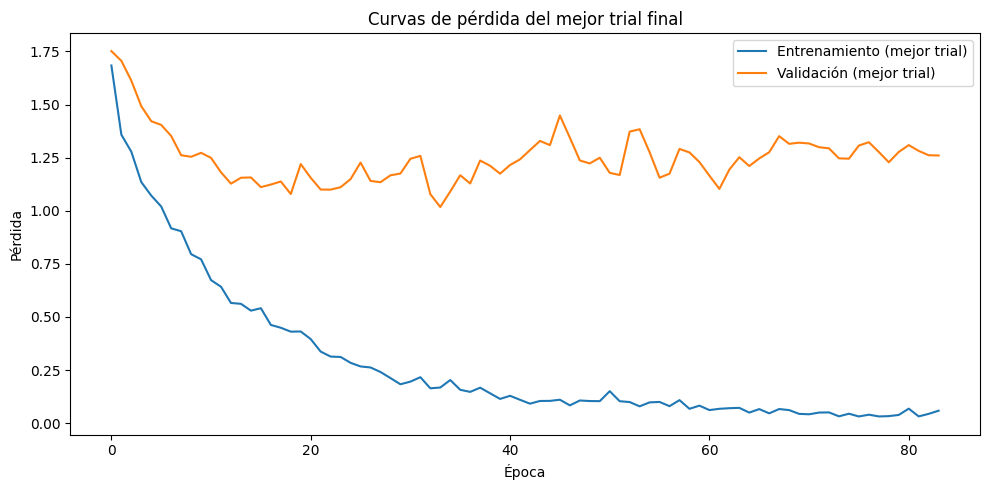

In [36]:
# Graficar las curvas de pérdida de entrenamiento y validación para cada trial de Optuna

import matplotlib.pyplot as plt

# Si quieres graficar las curvas de entrenamiento y validación del mejor trial final:
if 'final_history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(final_history['train_loss'], label='Entrenamiento (mejor trial)')
    plt.plot(final_history['val_loss'], label='Validación (mejor trial)')
    plt.title('Curvas de pérdida del mejor trial final')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluación del Modelo Final y Visualización de Resultados

In [37]:
# Asegurando de que las variables de módulos anteriores estén disponibles
if ('test_loader' not in locals() or test_loader is None or
    'device' not in locals() or
    'FINAL_BEST_MODEL_PATH' not in locals() or not os.path.exists(FINAL_BEST_MODEL_PATH) or
    'idx_to_class' not in locals() or 'num_classes' not in locals() or
    'SimpleCNN' not in locals()):
     print("Error: Variables o componentes de módulos anteriores no encontrados o invalidos para la evaluación.")     
     # Intenta cargar info esencial si el checkpoint existe pero las vars no están en locals()
     if os.path.exists(FINAL_BEST_MODEL_PATH):
         try:
             print(f"Intentando cargar información básica desde el checkpoint final: {FINAL_BEST_MODEL_PATH}")
             temp_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location='cpu') # Cargar a CPU temporalmente
             if 'num_classes' not in locals(): num_classes = temp_checkpoint.get('num_classes')
             if 'idx_to_class' not in locals(): idx_to_class = temp_checkpoint.get('idx_to_class')
             print("Información básica cargada desde checkpoint.")
         except Exception as e:
             print(f"Error al cargar información básica del checkpoint: {e}")

     # Verificar si, tras el intento, aún faltan variables
     if ('test_loader' not in locals() or test_loader is None or 'device' not in locals() or
         'num_classes' not in locals() or num_classes is None or 'idx_to_class' not in locals() or idx_to_class is None or
         'SimpleCNN' not in locals()):
          raise RuntimeError("Faltan componentes necesarios para la evaluación final incluso después de intentar cargar info del checkpoint.")


print(f"\nDispositivo de evaluación: {device}")
print(f"Usando DataLoader de prueba con {len(test_loader.dataset)} muestras.")
print(f"Ruta del mejor modelo FINAL a cargar: {FINAL_BEST_MODEL_PATH}")
print(f"Número de clases (verificado): {num_classes}")


Dispositivo de evaluación: cuda
Usando DataLoader de prueba con 45 muestras.
Ruta del mejor modelo FINAL a cargar: ./Resultados/final_model\final_best_optuna_model.pth
Número de clases (verificado): 6


In [38]:

# Cargar el Mejor Modelo Entrenado con HPs Óptimos
# Intentar cargar el checkpoint del mejor modelo guardado.
print("Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...")

try:
    if 'SimpleCNN' not in locals():
         raise RuntimeError("La clase SimpleCNN no está definida.")

    checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)

     #Creamos una variable local 'final_model_eval'.
    final_model_eval = SimpleCNN(num_classes=num_classes)

    # Aplicar HPs del checkpoint si modifican la arquitectura (ej. dropout)
    # Asegurarse de que los HPs fueron guardados en el checkpoint del Módulo 6.
    if 'hps' in checkpoint and checkpoint['hps'] is not None:
         loaded_hps = checkpoint['hps']
         print(f"  HPs cargados desde el checkpoint: {loaded_hps}")
         if 'dropout_rate' in loaded_hps:
              tuned_dropout_rate = loaded_hps['dropout_rate']
              for module in final_model_eval.modules():
                   if isinstance(module, nn.Dropout):
                        module.p = tuned_dropout_rate
              print(f"  Ajustada tasa de dropout en el modelo cargado a: {tuned_dropout_rate:.2f}")
    else:
        print("  Advertencia: HPs no encontrados en el checkpoint final. No se aplicaron ajustes de arquitectura basados en HPs.")


    final_model_eval.load_state_dict(checkpoint['model_state_dict'])

    # Asegurando que el modelo está en el dispositivo correcto
    final_model_eval.to(device)

    # Recuperar información de clases del checkpoint por si acaso
    if 'idx_to_class' in checkpoint:
         idx_to_class = checkpoint['idx_to_class']
    if 'num_classes' in checkpoint:
         num_classes = checkpoint['num_classes']

    print("Mejor modelo de Optuna cargado exitosamente para evaluación.")

except Exception as e:
    print(f"Error FATAL al cargar el checkpoint '{FINAL_BEST_MODEL_PATH}': {e}")
    print("La evaluación no puede continuar sin un modelo cargado.")
    raise # Detener la ejecución si el modelo no se carga

# Asegurarse de que num_classes e idx_to_class están disponibles tras la carga/verificación inicial
if num_classes is None or idx_to_class is None:
     raise RuntimeError("No se pudo obtener la información de clase necesaria para la evaluación.")

target_names = [idx_to_class[i] for i in range(num_classes)]
print(f"Nombres de clases para métricas: {target_names}")

Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...
Tamaño de entrada calculado para la capa lineal: 99200
  HPs cargados desde el checkpoint: {'learning_rate': 0.00041911199311056, 'weight_decay': 2.581474647260134e-05, 'dropout_rate': 0.289607268498357, 'optimizer': 'Adam'}
  Ajustada tasa de dropout en el modelo cargado a: 0.29
Mejor modelo de Optuna cargado exitosamente para evaluación.
Nombres de clases para métricas: ['ah64', 'chinook', 'cougar', 'f15', 'f16', 'seahawk']


In [39]:
# Evaluación en el Conjunto de prueba
final_model_eval.eval() # Pone el modelo en modo evaluación
print("\nEvaluando el modelo en el conjunto de prueba...")

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_labels = []
all_predictions = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Monitorización de VRAM antes de la evaluación
    if device.type == 'cuda':
        torch.cuda.empty_cache() # Limpiar caché por si acaso
        print(f"  VRAM al inicio de la evaluación: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    for i, (inputs, labels) in enumerate(test_loader):
        # Mover datos al dispositivo
        inputs = inputs.to(device)
        # Las etiquetas no necesitan gradientes, pero sí deben estar en el mismo dispositivo si se usan en cálculos intermedios
        # En este caso, las guardaremos para la CPU más tarde.

        # Forward pass
        outputs = final_model_eval(inputs) # Usar el modelo cargado para evaluación

        # Obtener las predicciones (índice de la clase con mayor score)
        _, predicted = torch.max(outputs.data, 1)

        # Mover predicciones y etiquetas a la CPU antes de almacenarlas
        # Esto es CRUCIAL para no agotar la VRAM al acumular todas las predicciones/etiquetas
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Las etiquetas originales del loader ya pueden estar en CPU, pero mejor asegurar.

# Convertir listas a arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("Evaluación completada.")


Evaluando el modelo en el conjunto de prueba...
  VRAM al inicio de la evaluación: 613.91 MB
Evaluación completada.


## Métricas de Evaluación en el Conjunto de Prueba

In [40]:
#Cálculo e Impresión de Métricas de Evaluación

# Precisión general (Accuracy)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precisión (Accuracy): {accuracy:.4f}")

# Reporte completo de clasificación (incluye precision, recall, f1-score por clase y promedios)
# target_names son los nombres de las clases en el mismo orden que los índices numéricos (0, 1, 2, ...)

print("\nReporte de Clasificación:")

try:
    print(classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0))
except Exception as e:
     print(f"Error al generar el reporte de clasificación: {e}")
     print("Reporte básico sin target_names:")
     print(classification_report(all_labels, all_predictions, zero_division=0))

Precisión (Accuracy): 0.7778

Reporte de Clasificación:
              precision    recall  f1-score   support

        ah64       0.75      0.86      0.80         7
     chinook       1.00      0.71      0.83         7
      cougar       0.73      1.00      0.84         8
         f15       0.67      0.50      0.57         8
         f16       0.78      0.88      0.82         8
     seahawk       0.83      0.71      0.77         7

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.77        45




Matriz de Confusión (numpy array):


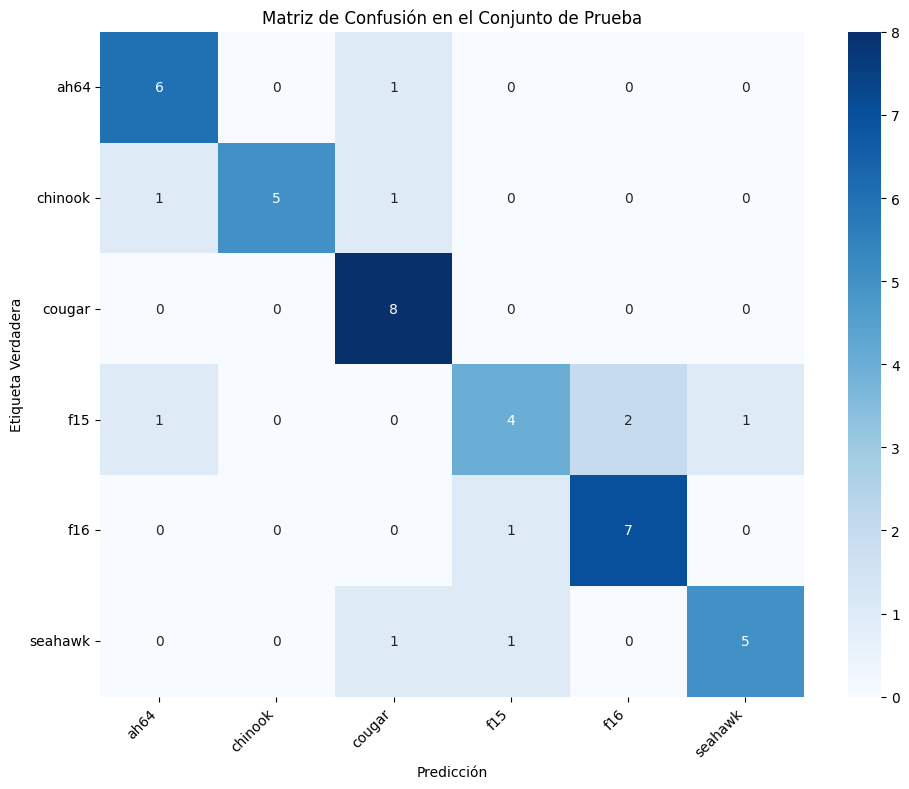

In [41]:
# Matriz de Confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nMatriz de Confusión (numpy array):")
# print(conf_matrix) # Imprimir la matriz numpy si quieres

# 4. Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
# Usar seaborn para una visualización más atractiva
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Visualización de Ejemplos de Predicción

Cargando un lote del test_loader para visualización de predicciones...


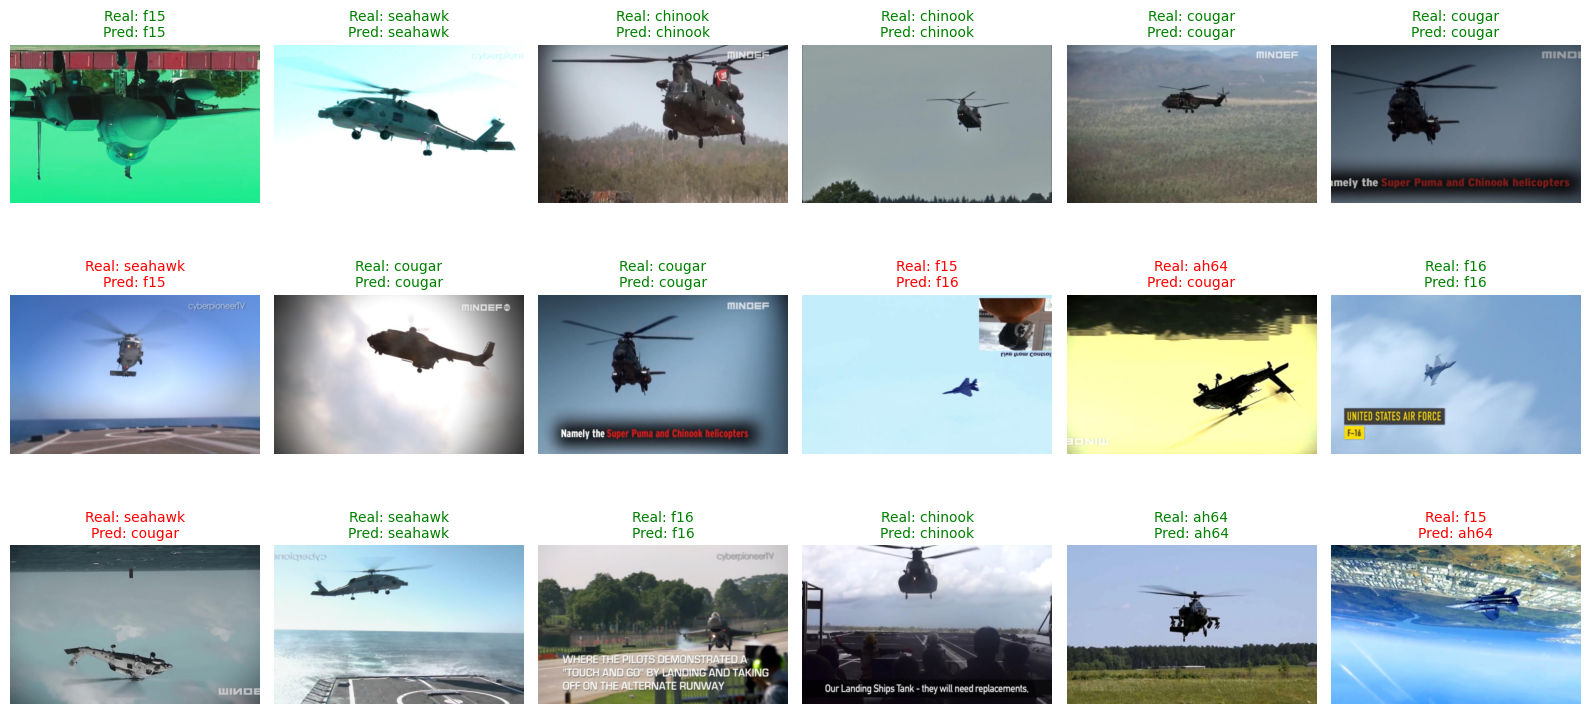

  VRAM después de visualización de ejemplos: 613.91 MB


In [42]:
# Función para de-normalizar una imagen (necesaria si quieres ver la imagen original)
# Esta función asume la media y std de ImageNet que usamos en M2/M3
def denormalize(tensor, mean=mean_list, std=std_list):
    """Denormaliza un tensor de imagen (C, H, W) con media y std dadas."""
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    # Asegurarse de que mean y std están en el mismo dispositivo que el tensor
    mean = mean.cpu()
    std = std.cpu()

    # Esta función espera un tensor (C, H, W) o un lote (B, C, H, W)
    if tensor.dim() == 3: # (C, H, W)
         tensor = tensor.unsqueeze(0) # Añadir dimensión de lote temporal
         denorm_tensor = tensor * std + mean
         denorm_tensor = denorm_tensor.squeeze(0) # Eliminar dimensión de lote
    elif tensor.dim() == 4: # (B, C, H, W)
         denorm_tensor = tensor * std + mean
    else:
        raise ValueError("Formato de tensor incorrecto para denormalización. Espera (C, H, W) o (B, C, H, W).")


    # Asegurar que los valores estén en el rango [0, 1] para visualización
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)
    return denorm_tensor

# Obtener algunas imágenes de ejemplo del test_loader
print("Cargando un lote del test_loader para visualización de predicciones...")
try:
    # Configurar el test_loader para no barajar y tomar el primer lote
    data_iter = iter(test_loader)
    test_images_batch, test_labels_batch = next(data_iter)

    # Hacer predicciones para este lote específico    
    final_model_eval.eval()
    with torch.no_grad():
         # Mover solo el lote actual al dispositivo para la predicción
         batch_images_device = test_images_batch.to(device)
         batch_outputs = final_model_eval(batch_images_device)
         _, batch_predicted = torch.max(batch_outputs.data, 1)
         batch_predicted = batch_predicted.cpu() # Mover predicciones a CPU

    # De-normalizar las imágenes para mostrarlas (pasando el tensor del batch)
    test_images_display_batch = denormalize(test_images_batch)

    # Convertir a numpy para matplotlib y permutar dimensiones (B, C, H, W) -> (B, H, W, C)
    test_images_display_batch = test_images_display_batch.permute(0, 2, 3, 1).numpy()
    test_labels_np = test_labels_batch.numpy()
    batch_predicted_np = batch_predicted.numpy()

    # Mostrar algunas imágenes con sus etiquetas verdaderas y predichas
    # Determinar cuántas imágenes mostrar (ej. un máximo de 18 en 3x6)
    num_images_to_show = min(len(test_images_display_batch), 18)
    fig, axes = plt.subplots(3, 6, figsize=(16, 8)) 
    axes = axes.ravel() # Aplanar la matriz de ejes

    for i in range(num_images_to_show):
        ax = axes[i]
        ax.imshow(test_images_display_batch[i])
        true_class = idx_to_class[test_labels_np[i]]
        predicted_class = idx_to_class[batch_predicted_np[i]]
        color = 'green' if true_class == predicted_class else 'red'
        title = f"Real: {true_class}\nPred: {predicted_class}"
        ax.set_title(title, color=color, fontsize=10) 
        ax.axis('off') # Ocultar ejes

    # Ocultar ejes restantes si mostramos menos de 18 imágenes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Liberar tensores
    del data_iter, test_images_batch, test_labels_batch, batch_images_device, batch_outputs, batch_predicted, test_images_display_batch, test_labels_np, batch_predicted_np
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de visualización de ejemplos: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

except Exception as e:
    print(f"\nError al intentar visualizar ejemplos de predicción: {e}")
    print("Asegúrate de que matplotlib, seaborn y torchvision están correctamente instalados y que hay suficientes imágenes en el test_loader.")


# Limpieza de memoria 
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [43]:
#%pip install winsound

In [44]:
import winsound
import time

# Frecuencia (Hz) y duración (ms)
frequency = 500
duration = 100
pause_duration = 0.5  # seconds

for _ in range(3):
    winsound.Beep(frequency=frequency, duration=duration)
    time.sleep(pause_duration)
